In [2]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy.stats import norm

In [3]:

class CausalGenerator:
    def __init__(self, graph, data,unit_vars,subunit_vars,sizes):
        self.graph = nx.DiGraph(graph)
        self.data = data
        self.processed_data = self.preprocess_data(unit_vars,subunit_vars,sizes)
        
    def preprocess_data(self,unit_vars,subunit_vars,sizes):
        # Aggregate subunit nodes
        data = {}
        
        for var in unit_vars:
            for i in range(len(sizes)):
                data[var+str(i)] = self.data[var+str(i)]
        for var in subunit_vars:
            for i in range(len(sizes)):
                s=0
                for j in range(sizes[i]):
                    s+=self.data['_'+var+str(i)+'_'+str(j)]
            data[var] = s/sizes[i]
        return data
    
    
    def generate(self, noise_dist, transition_funcs, sizes):
        generated = {}
        for node in nx.topological_sort(self.graph):
            for i in range(len(sizes)):
                x=np.random.uniform()
                parents = list(self.graph.predecessors(node))
                if not parents:
                    generated[node+str(i)] = noise_dist[node](x)
                else:
                    parent_values = [generated[p+str(i)] for p in parents]
                    generated[node+str(i)] = transition_funcs[node](*parent_values) + noise_dist[node](x)
        
        # Convert to pandas DataFrame
        return generated
        

In [4]:
import json

def load_data_from_json(file_path):
    """
    Load data from a JSON file and return it as a dictionary.
    
    :param file_path: Path to the JSON file
    :return: Dictionary containing the loaded data
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        print(f"Data successfully loaded from {file_path}")
        return data
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON format in {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None



In [5]:
data = load_data_from_json('data/sampled_data.json')


Data successfully loaded from data/sampled_data.json


In [6]:

# Example usage:
graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]

unit_vars = ['a', 'c', 'e']
subunit_vars = ['d', 'b']
sizes = [150]*150

generator = CausalGenerator(graph, data,unit_vars,subunit_vars,sizes)
noise_dist = {
    'a': lambda x: norm.ppf(x),
    '_b': lambda x: norm.ppf(x, loc=0, scale=1),
    'c': lambda x: norm.ppf(x, loc=0, scale=1),
    '_d': lambda x: norm.ppf(x, loc=0, scale=1),
    'e': lambda x: norm.ppf(x, loc=0, scale=1)
}

transition_funcs = {
    '_b': lambda a: a,
    'c': lambda a, b: a**3 + (b+1)**2,
    '_d': lambda b, c: b+1 - c,
    'e': lambda c, d: c + d+1
}

In [7]:

generated_data = generator.generate(noise_dist, transition_funcs,sizes)

In [8]:
print(generated_data)


{'a0': 1.5249539146128972, 'a1': -0.16805956964146865, 'a2': -0.4383154042841639, 'a3': -1.3114944993210913, 'a4': -0.6106177658141418, 'a5': 0.47567022811639176, 'a6': 2.0912326075159307, 'a7': 1.610828350812103, 'a8': 1.7351764922499826, 'a9': -0.16688706471254855, 'a10': 2.593937100278946, 'a11': -0.22354782014657398, 'a12': 0.01564642581848941, 'a13': 1.1116459033420352, 'a14': 0.6250244225549454, 'a15': 0.7711593832868482, 'a16': -0.02562204581583186, 'a17': -1.4433939882840643, 'a18': 0.43091564826052176, 'a19': -0.666611716576559, 'a20': 1.0099653340089065, 'a21': -0.07956055937044391, 'a22': -1.090794672535177, 'a23': -0.02722590117108365, 'a24': 0.15541837345020804, 'a25': -1.2514695189113856, 'a26': 0.8049865399513537, 'a27': 0.016387889319473856, 'a28': -0.13177369398599678, 'a29': 0.7688608275873499, 'a30': -1.1046301738087205, 'a31': 0.2218080883106728, 'a32': 0.6842191262280735, 'a33': 0.337348425011976, 'a34': 0.6413735748257136, 'a35': 0.5402024503710116, 'a36': -0.8073

In [9]:
# Generate arrays for each variable
a_array = [generated_data[f'a{k}'] for k in range(len(sizes))]
b_array = [generated_data[f'_b{k}'] for k in range(len(sizes))]
c_array = [generated_data[f'c{k}'] for k in range(len(sizes))]
d_array = [generated_data[f'_d{k}'] for k in range(len(sizes))]
e_array = [generated_data[f'e{k}'] for k in range(len(sizes))]

# Print the arrays
print("a arrays:", a_array)
print("b arrays:", b_array)
print("c arrays:", c_array)
print("d arrays:", d_array)
print("e arrays:", e_array)


a arrays: [1.5249539146128972, -0.16805956964146865, -0.4383154042841639, -1.3114944993210913, -0.6106177658141418, 0.47567022811639176, 2.0912326075159307, 1.610828350812103, 1.7351764922499826, -0.16688706471254855, 2.593937100278946, -0.22354782014657398, 0.01564642581848941, 1.1116459033420352, 0.6250244225549454, 0.7711593832868482, -0.02562204581583186, -1.4433939882840643, 0.43091564826052176, -0.666611716576559, 1.0099653340089065, -0.07956055937044391, -1.090794672535177, -0.02722590117108365, 0.15541837345020804, -1.2514695189113856, 0.8049865399513537, 0.016387889319473856, -0.13177369398599678, 0.7688608275873499, -1.1046301738087205, 0.2218080883106728, 0.6842191262280735, 0.337348425011976, 0.6413735748257136, 0.5402024503710116, -0.8073322438421402, -1.5198638592353773, -1.1136744319471537, 1.930499193829165, 0.012812085705029648, -1.43518179659832, 0.14331805139076037, 1.572785624238128, 0.8383026726938242, -0.6444711223250654, -0.18365797704693418, -0.185004611006364, 

In [10]:
original_e = [data['e'+str(k)] for k in range(len(sizes))]

In [11]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.integrate import quad


In [12]:

def kl_divergence(p, q):
    def integrand(x):
        px = p(x)
        qx = q(x)
        # Avoid log(0) by adding a small epsilon
        epsilon = 1e-10
        return np.where((px > 0) & (qx > 0),
                        px * (np.log(px + epsilon) - np.log(qx + epsilon)),
                        0)
    
    result, _ = quad(integrand, -np.inf, np.inf, limit=1000)
    return result


In [13]:

def kl_divergence(p, q, bandwidth='scott'):
    """
    Calcule la divergence KL entre deux distributions empiriques représentées par des tableaux,
    en utilisant l'estimation de densité par noyau.
    
    :param p: Premier tableau de données
    :param q: Second tableau de données
    :param bandwidth: Méthode pour estimer la largeur de bande ('scott', 'silverman' ou un nombre)
    :return: Valeur de la divergence KL
    """
    # Assurez-vous que les tableaux ont la même taille
    min_len = min(len(p), len(q))
    p = p[:min_len]
    q = q[:min_len]
    
    # Estimation de densité par noyau
    kde_p = gaussian_kde(p, bw_method=bandwidth)
    kde_q = gaussian_kde(q, bw_method=bandwidth)
    
    # Créez un espace d'échantillonnage
    x = np.linspace(min(np.min(p), np.min(q)), max(np.max(p), np.max(q)), 10000)
    
    # Estimez les densités
    p_density = kde_p(x)
    q_density = kde_q(x)
    
    # Ajoutez un petit epsilon pour éviter la division par zéro
    epsilon = 1e-10
    p_density += epsilon
    q_density += epsilon
    
    # Normalisez les densités
    p_density /= np.sum(p_density)
    q_density /= np.sum(q_density)
    
    # Calculez la divergence KL
    return np.sum(p_density * np.log(p_density / q_density))

In [14]:

# Select two arrays for comparison
array1 = e_array  # First array from e_arrays
array2 = [data[f'e{i}'] for i in range(150)]  # Second array from the original data

arrayA = [data[f'a{i}'] for i in range(150)]  # Second array from the original data
arrayB = [np.mean(np.array([data[f'_b{i}_{j}'] for j in range(150)])) for i in range(150)]  # Second array from the original data
arrayC = [data[f'c{i}'] for i in range(150)]  # Second array from the original data



arrayB_full = np.array([[data[f'_b{i}_{j}'] for i in range(150)] for j in range(150)])  # Second array from the original data
arrayD_full =np.array([[data[f'_d{i}_{j}'] for i in range(150)] for j in range(150)])   # Second array from the original data

In [15]:

# Compute KL divergence
kl_div = kl_divergence(array1, array2)

# Print the KL divergence
print(f"KL divergence between the two arrays E: {kl_div}")
 # high kl div okay
 
kl_div = kl_divergence(arrayA, a_array)
print(f"KL divergence between the two arrays A: {kl_div}")

kl_div = kl_divergence(arrayB, b_array)
print(f"KL divergence between the two arrays B: {kl_div}")

kl_div = kl_divergence(arrayC, c_array)
print(f"KL divergence between the two arrays C: {kl_div}")

KL divergence between the two arrays E: 7.022863329751435
KL divergence between the two arrays A: 0.01984372331949836
KL divergence between the two arrays B: 0.07696541639445302
KL divergence between the two arrays C: 0.13025328438655023


/tmp/ipykernel_98968/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_98968/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


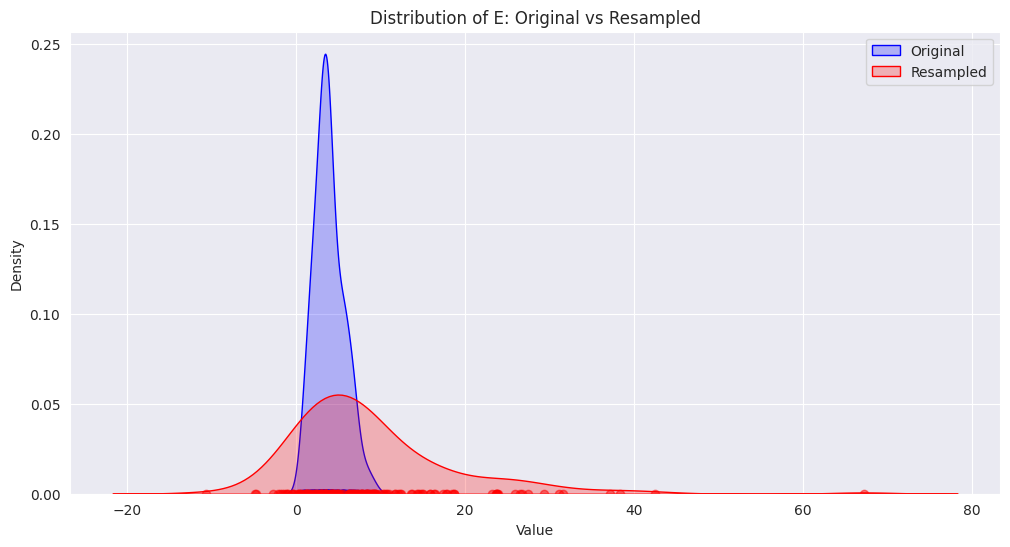

/tmp/ipykernel_98968/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_98968/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


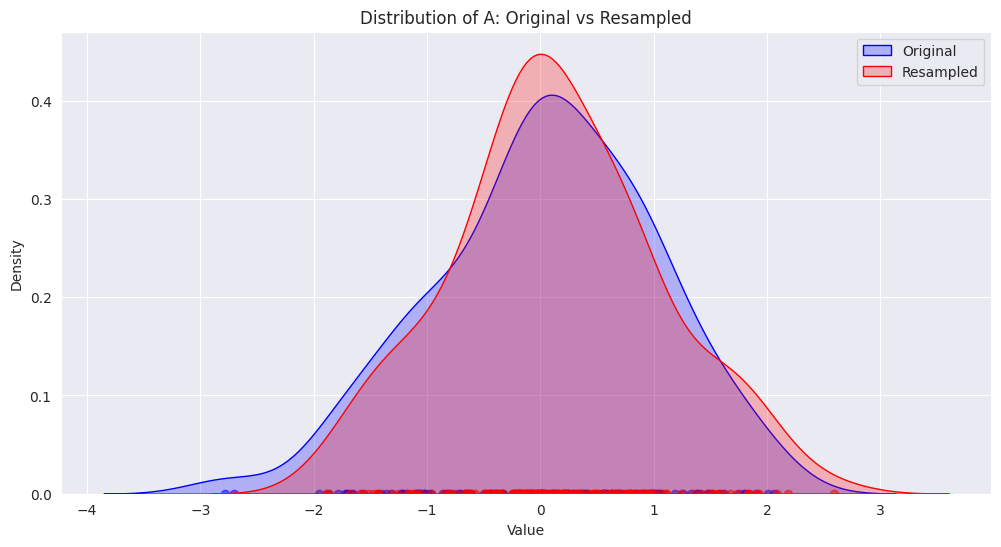

/tmp/ipykernel_98968/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_98968/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


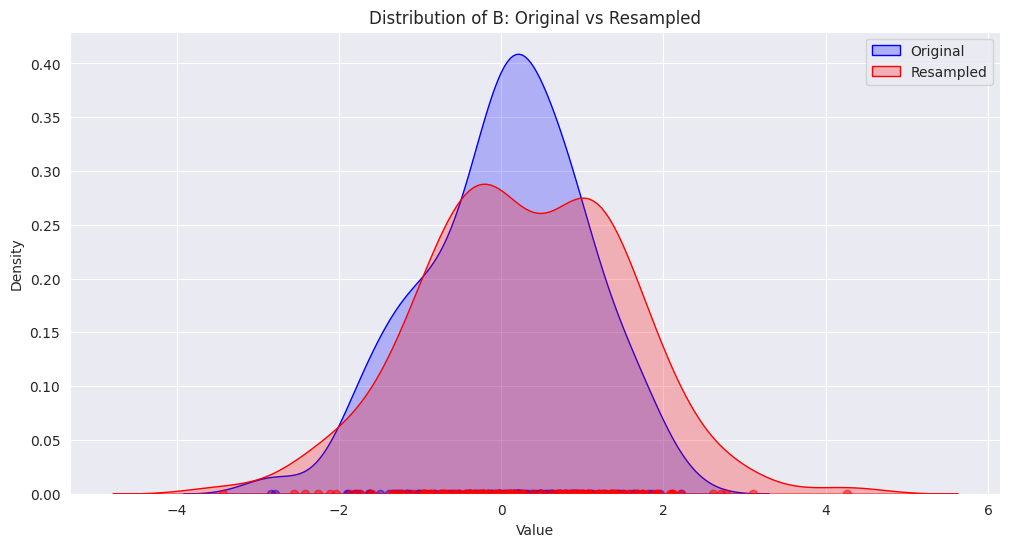

/tmp/ipykernel_98968/526034867.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(original, shade=True, color="blue", label="Original")
/tmp/ipykernel_98968/526034867.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(resampled, shade=True, color="red", label="Resampled")


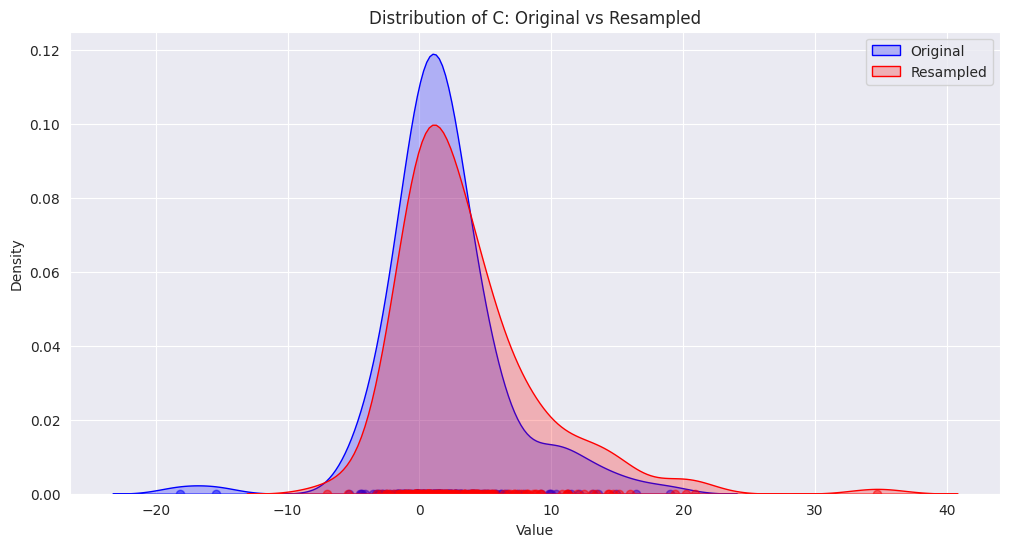

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_arrays_with_kde(original, resampled, title):
    plt.figure(figsize=(12, 6))
    
    # Plot original data
    sns.kdeplot(original, shade=True, color="blue", label="Original")
    plt.scatter(original, [0]*len(original), color="blue", alpha=0.5)
    
    # Plot resampled data
    sns.kdeplot(resampled, shade=True, color="red", label="Resampled")
    plt.scatter(resampled, [0]*len(resampled), color="red", alpha=0.5)
    
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

# Plot for E
plot_arrays_with_kde(array2, array1, "Distribution of E: Original vs Resampled")

# Plot for A
plot_arrays_with_kde(arrayA, a_array, "Distribution of A: Original vs Resampled")

# Plot for B
plot_arrays_with_kde(arrayB, b_array, "Distribution of B: Original vs Resampled")

# Plot for C
plot_arrays_with_kde(arrayC, c_array, "Distribution of C: Original vs Resampled")


In [17]:
def experiment(n):
    kldivs= []
    for k in range(n):
        # Example usage:
        graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
        data = load_data_from_json(f'data/sampled_data_{k}.json')
        print(str(k) + " is in progress")
        
        unit_vars = ['a', 'c', 'e']
        subunit_vars = ['d', 'b']
        sizes = [150]*150
        
        generator = CausalGenerator(graph, data,unit_vars,subunit_vars,sizes)
        noise_dist = {
            'a': lambda x: norm.ppf(x),
            '_b': lambda x: norm.ppf(x, loc=0, scale=1),
            'c': lambda x: norm.ppf(x, loc=0, scale=1),
            '_d': lambda x: norm.ppf(x, loc=0, scale=1),
            'e': lambda x: norm.ppf(x, loc=0, scale=1)
        }
                
        transition_funcs = {
            '_b': lambda a: a,
            'c': lambda a, b: a**3 + (b+1)**2,
            '_d': lambda b, c: b+1 - c,
            'e': lambda c, d: c + d+1
        }
                
            
        generated_data = generator.generate(noise_dist, transition_funcs,sizes)

            # Generate arrays for each variable
        a_array = [generated_data[f'a{k}'] for k in range(len(sizes))]
        b_array = [generated_data[f'_b{k}'] for k in range(len(sizes))]
        c_array = [generated_data[f'c{k}'] for k in range(len(sizes))]
        d_array = [generated_data[f'_d{k}'] for k in range(len(sizes))]
        e_array = [generated_data[f'e{k}'] for k in range(len(sizes))]
            
            
        # Select two arrays for comparison
        array1 = e_array  # First array from e_arrays
        array2 = [data[f'e{i}'] for i in range(150)]  # Second array from the original data
        
        arrayA = [data[f'a{i}'] for i in range(150)]  # Second array from the original data
        arrayB = [np.mean(np.array([data[f'_b{i}_{j}'] for j in range(150)])) for i in range(150)]  # Second array from the original data
        arrayC = [data[f'c{i}'] for i in range(150)]  # Second array from the original data
        
        arrayD = [np.mean(np.array([data[f'_d{i}_{j}'] for j in range(150)])) for i in range(150)]  # Second array from the original data
        
        kldiv = {'c': kl_divergence(arrayC, c_array), 'b': kl_divergence(arrayB, b_array), 'a': kl_divergence(arrayA, a_array), 'd': kl_divergence(arrayD, d_array), 'e': kl_divergence(array2, array1)}
        
        
        kldivs.append(kldiv)
        
    return kldivs





    

In [18]:
kldivs = experiment(100)

Data successfully loaded from data/sampled_data_0.json
0 is in progress
Data successfully loaded from data/sampled_data_1.json
1 is in progress
Data successfully loaded from data/sampled_data_2.json
2 is in progress
Data successfully loaded from data/sampled_data_3.json
3 is in progress
Data successfully loaded from data/sampled_data_4.json
4 is in progress
Data successfully loaded from data/sampled_data_5.json
5 is in progress
Data successfully loaded from data/sampled_data_6.json
6 is in progress
Data successfully loaded from data/sampled_data_7.json
7 is in progress
Data successfully loaded from data/sampled_data_8.json
8 is in progress
Data successfully loaded from data/sampled_data_9.json
9 is in progress
Data successfully loaded from data/sampled_data_10.json
10 is in progress
Data successfully loaded from data/sampled_data_11.json
11 is in progress
Data successfully loaded from data/sampled_data_12.json
12 is in progress
Data successfully loaded from data/sampled_data_13.json
13

/tmp/ipykernel_98968/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_98968/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_98968/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
/tmp/ipykernel_98968/1427379182.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(kl_value

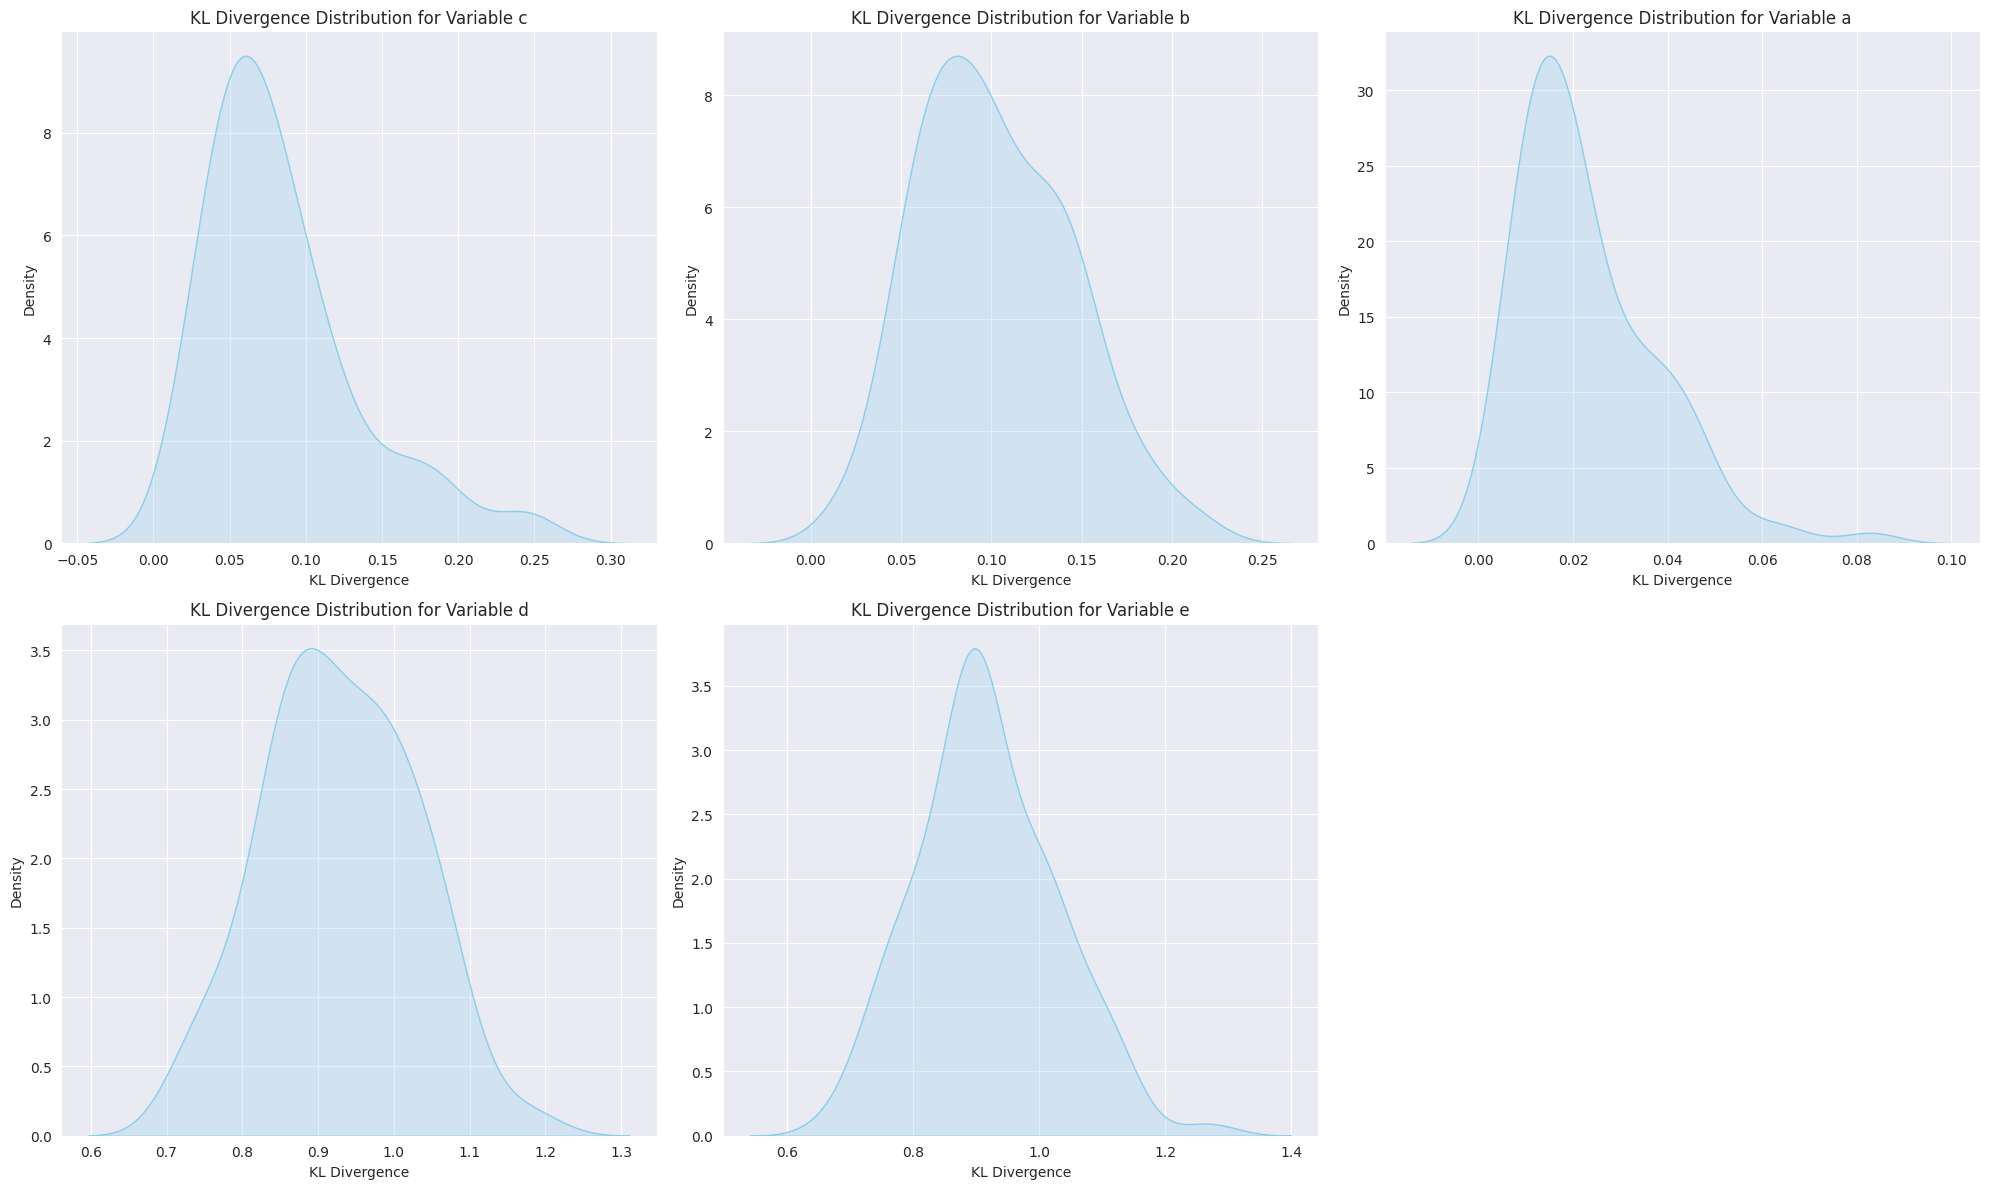

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
variables = list(kldivs[0].keys())  # Assuming kldivs is a list of dictionaries

# Create subplots for each variable
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    # Extract KL divergence values for the current variable
    kl_values = [kldiv[var] for kldiv in kldivs]
    
    # Create a KDE plot for the current variable
    sns.kdeplot(kl_values, ax=axes[i], shade=True, color='skyblue')
    
    # Customize the subplot
    axes[i].set_title(f'KL Divergence Distribution for Variable {var}')
    axes[i].set_xlabel('KL Divergence')
    axes[i].set_ylabel('Density')

# Remove the empty subplot
fig.delaxes(axes[5])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [20]:
import numpy as np

# Calculate mean and standard deviation for each variable
for var in variables:
    kl_values = [kldiv[var] for kldiv in kldivs]
    mean = np.mean(kl_values)
    std = np.std(kl_values)
    print(f"Variable {var}:")
    print(f"  Mean KL Divergence: {mean:.4f}")
    print(f"  Standard Deviation: {std:.4f}")
    print()


Variable c:
  Mean KL Divergence: 0.0846
  Standard Deviation: 0.0509

Variable b:
  Mean KL Divergence: 0.1021
  Standard Deviation: 0.0417

Variable a:
  Mean KL Divergence: 0.0230
  Standard Deviation: 0.0145

Variable d:
  Mean KL Divergence: 0.9280
  Standard Deviation: 0.0993

Variable e:
  Mean KL Divergence: 0.9168
  Standard Deviation: 0.1093



In [21]:
print(arrayB_full)

[[-1.47268991  1.63966332  0.40856952 ...  1.80029857 -1.9145164
   2.61437319]
 [-1.90013701  2.49629727  0.06182049 ...  1.0507217   0.53343335
   2.62197314]
 [-0.17438754  0.30047648  0.73672617 ... -0.33933136 -1.30662026
   2.27696595]
 ...
 [-0.41347473  1.89364913 -1.54786149 ... -0.94249159  0.13399317
   1.77570722]
 [-1.93329976 -0.42584108 -1.5365985  ...  0.14038374 -0.53876516
   1.53817683]
 [ 0.55570819  0.92623673 -0.40939622 ...  0.70443725 -1.15623655
   1.42182974]]


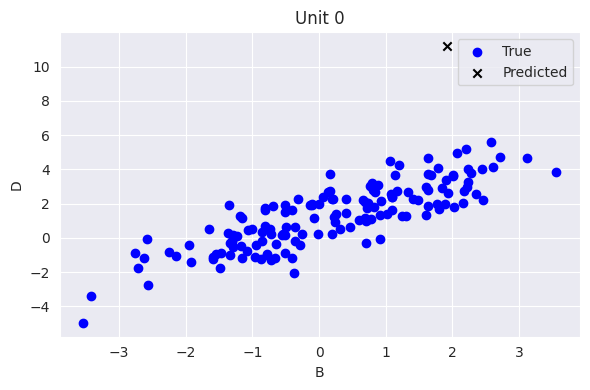

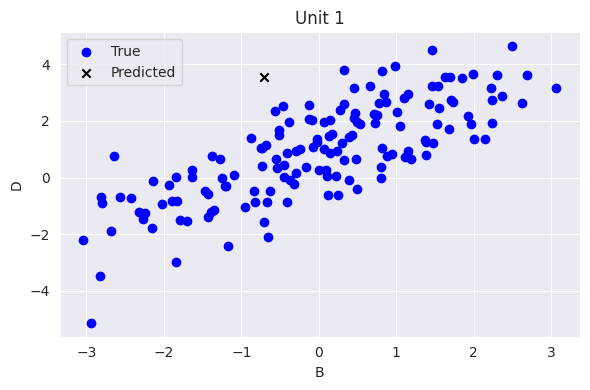

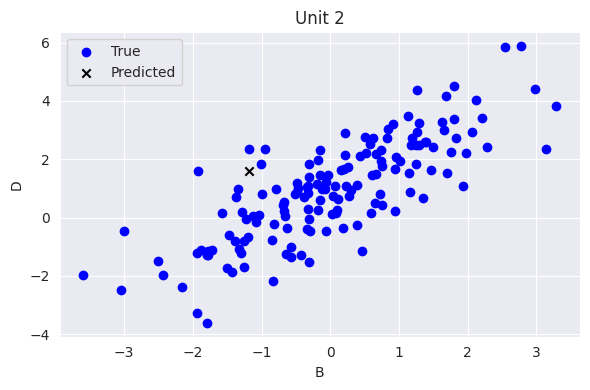

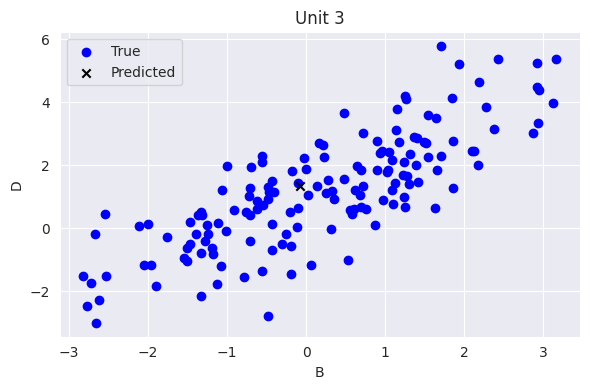

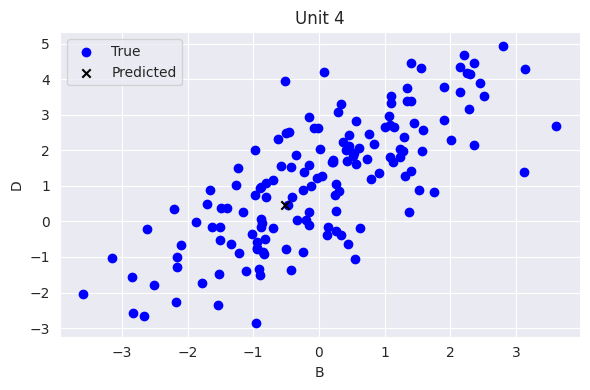

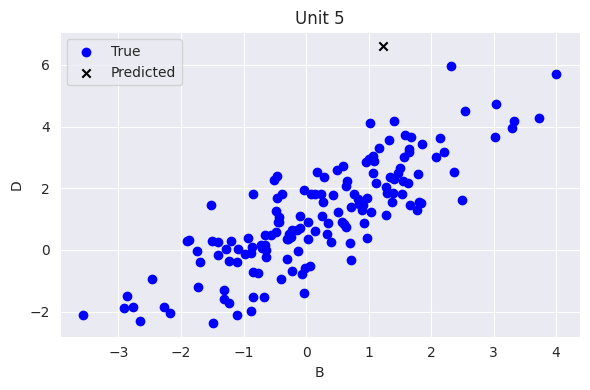

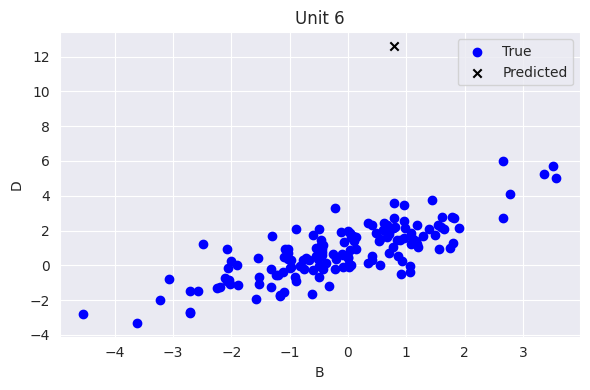

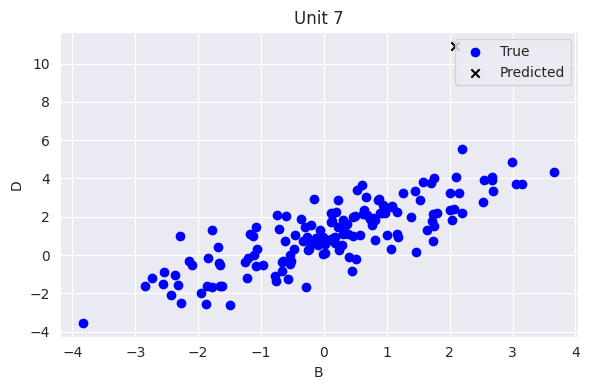

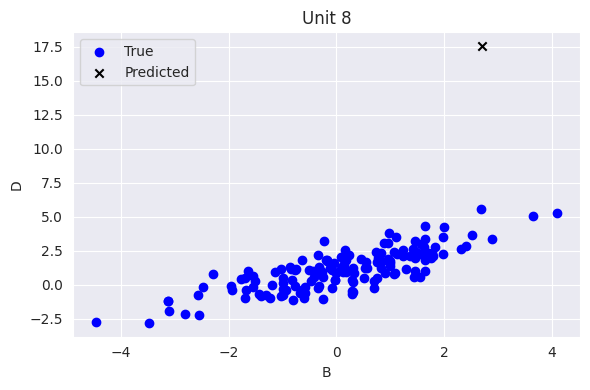

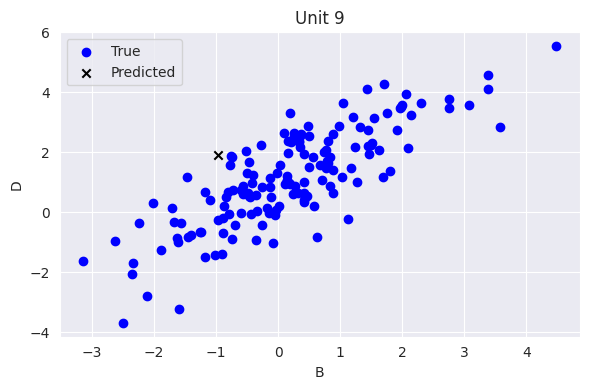

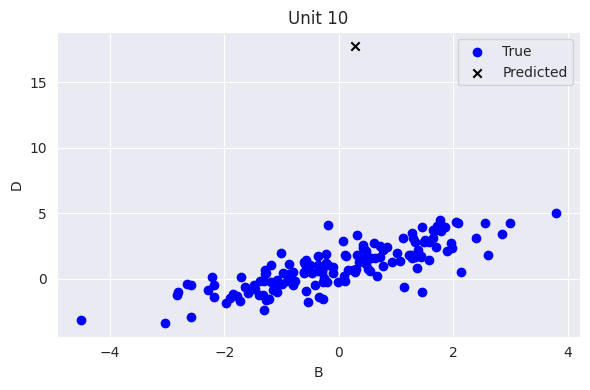

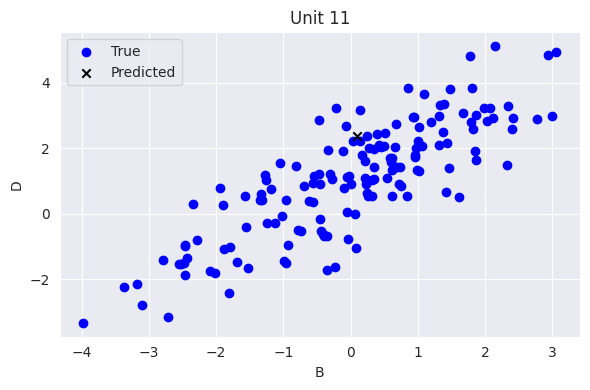

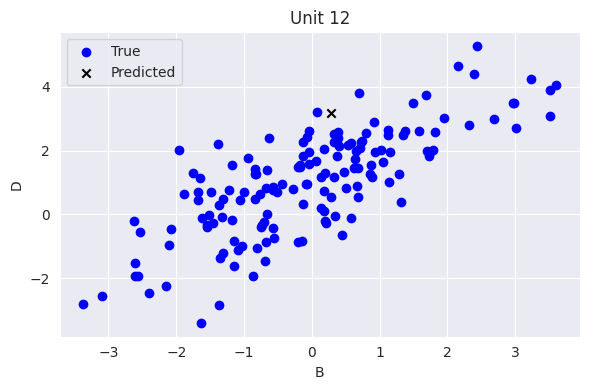

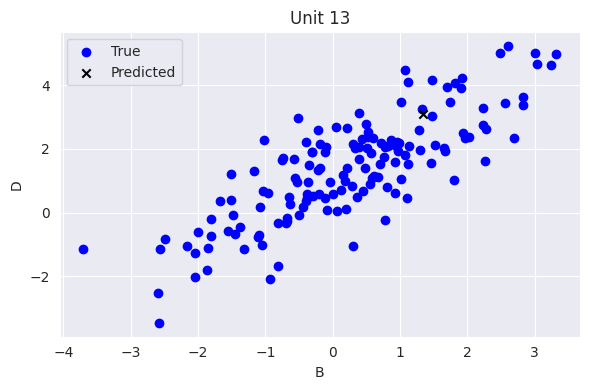

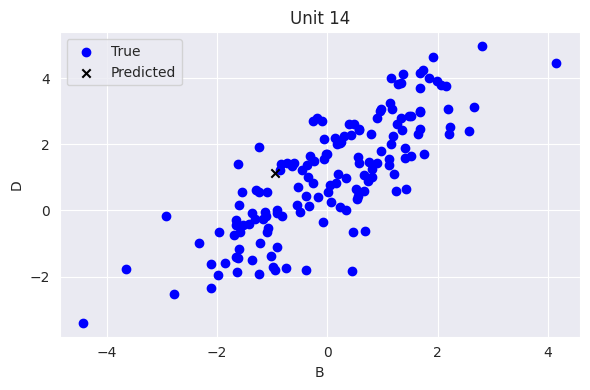

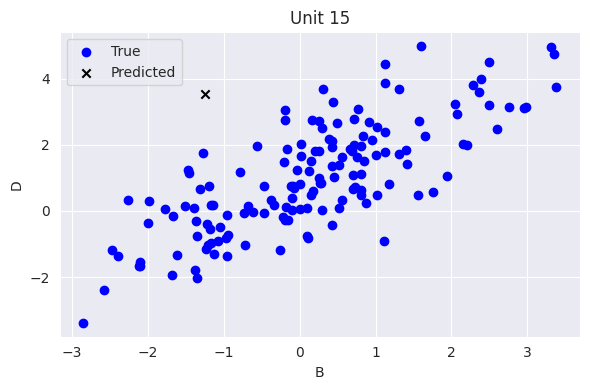

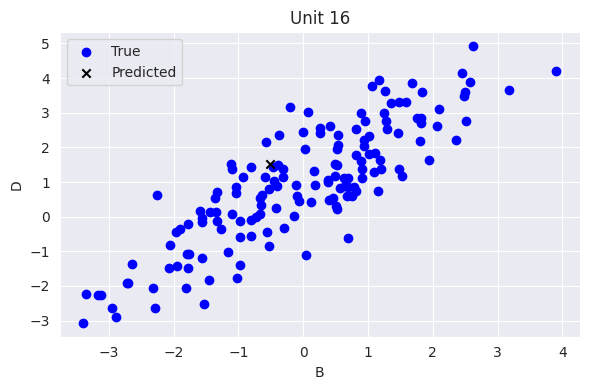

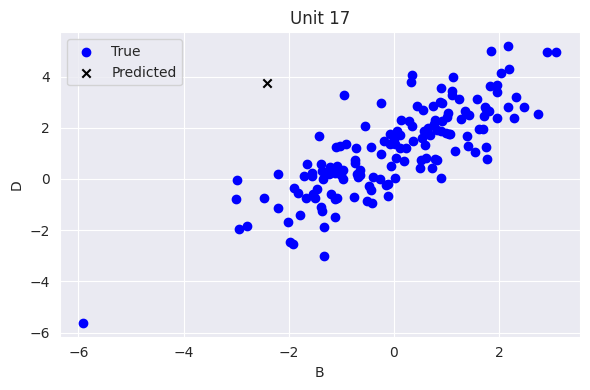

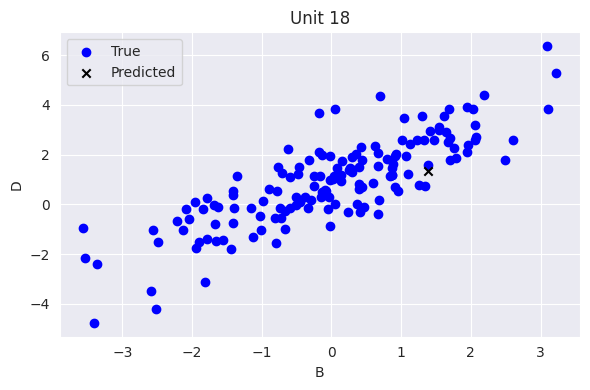

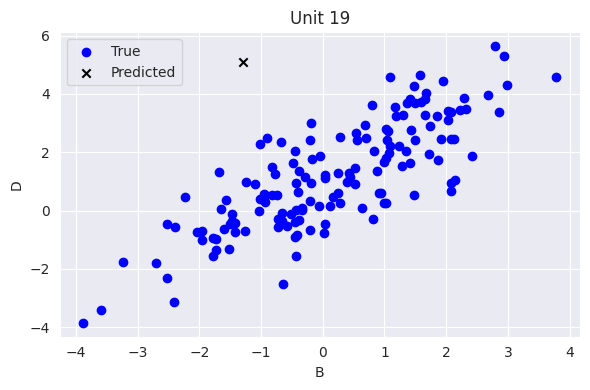

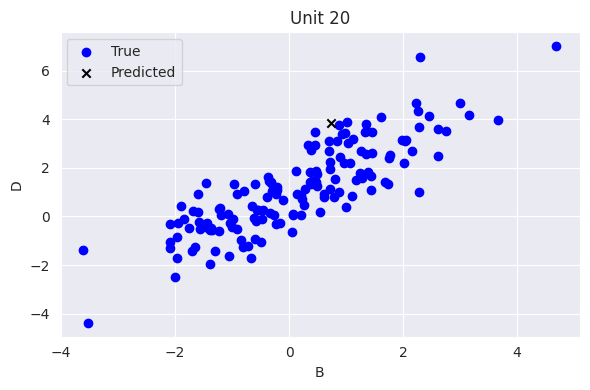

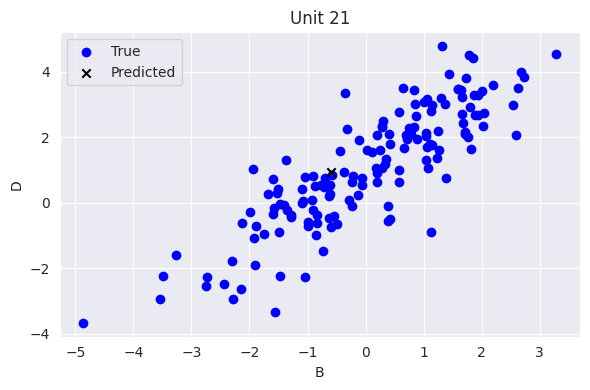

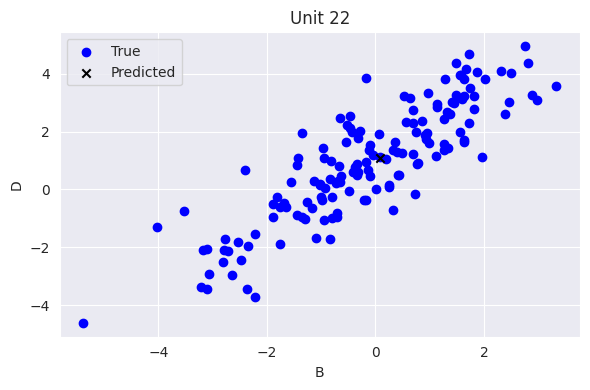

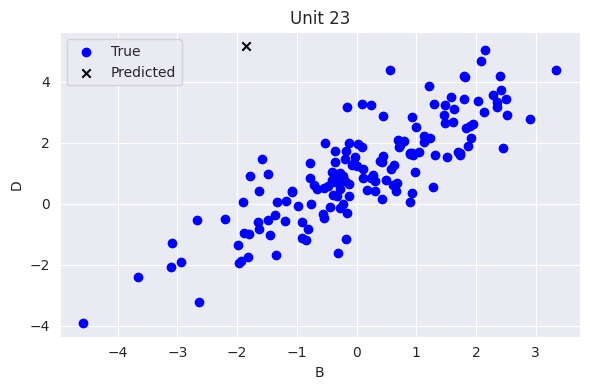

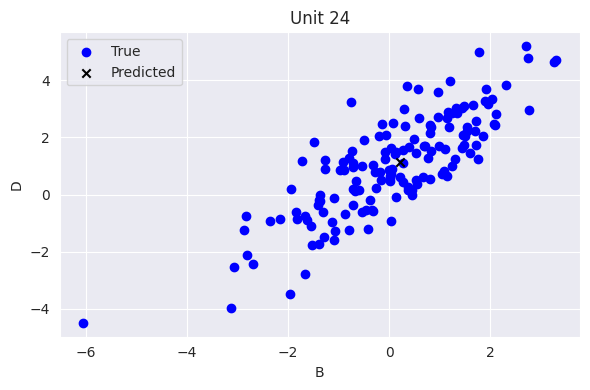

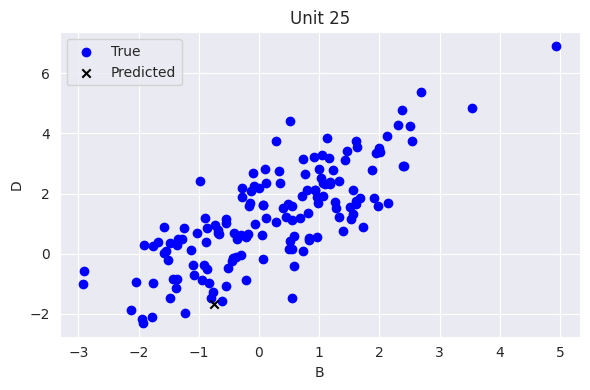

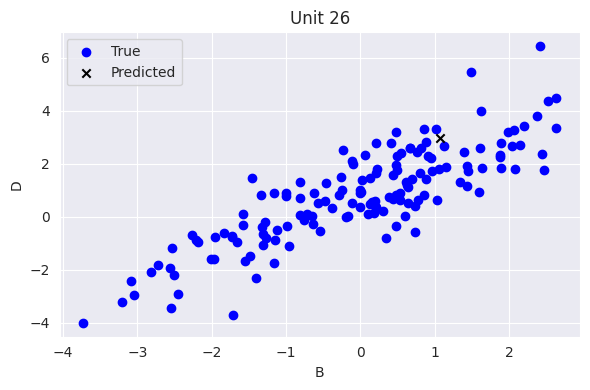

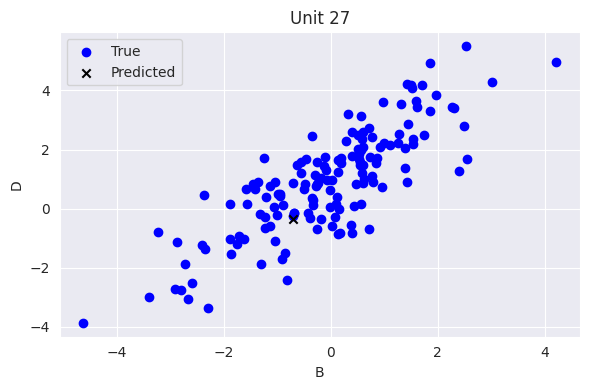

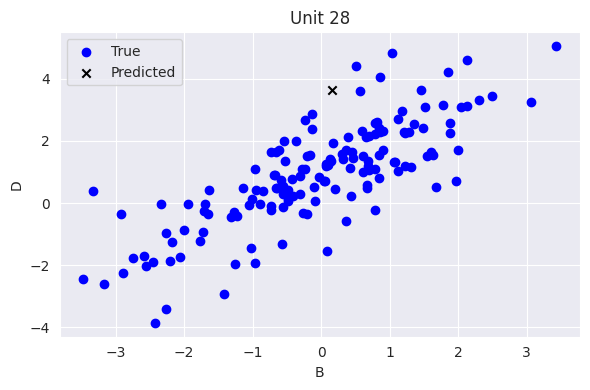

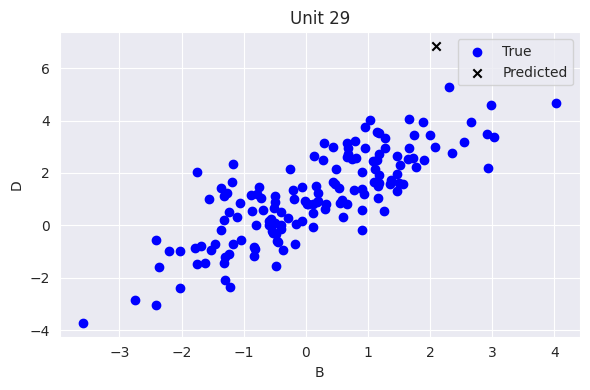

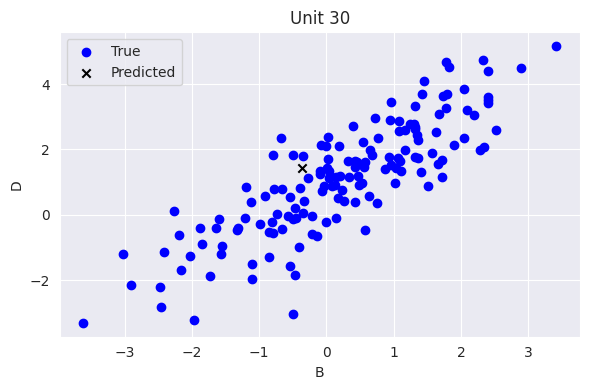

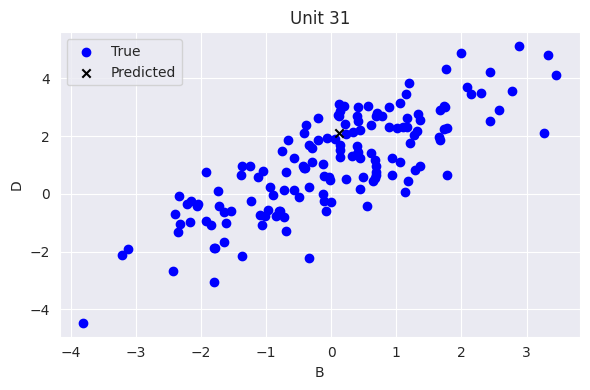

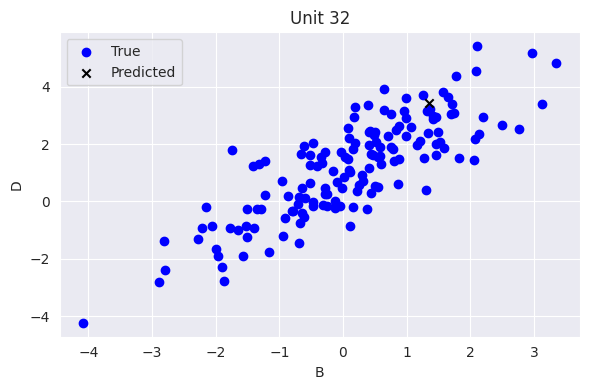

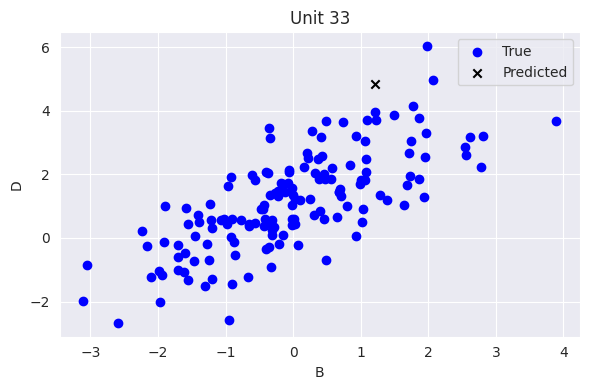

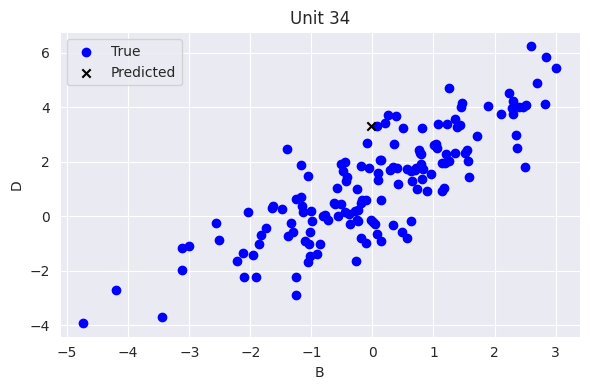

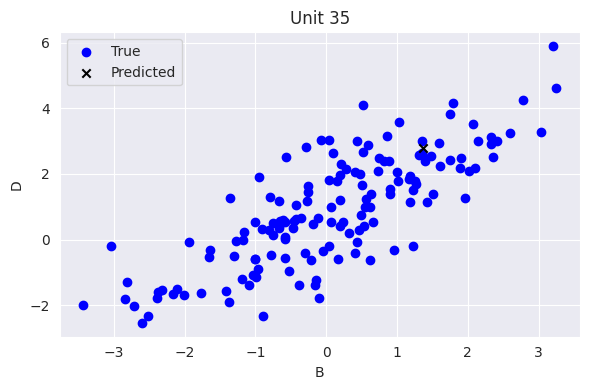

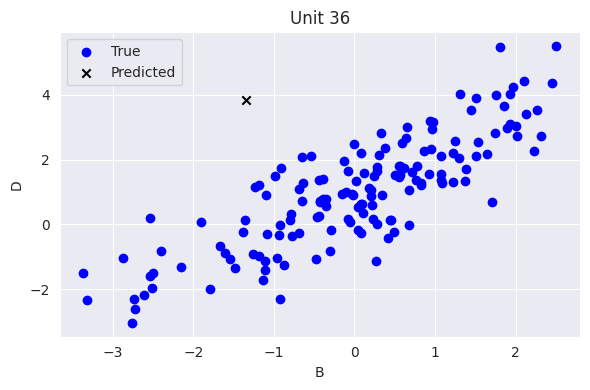

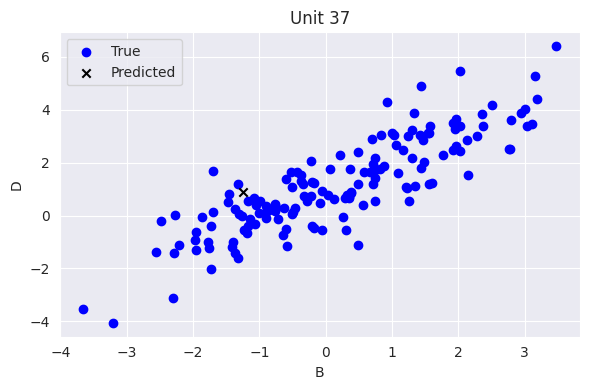

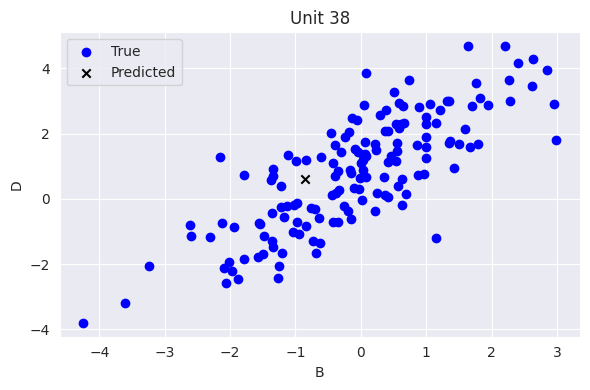

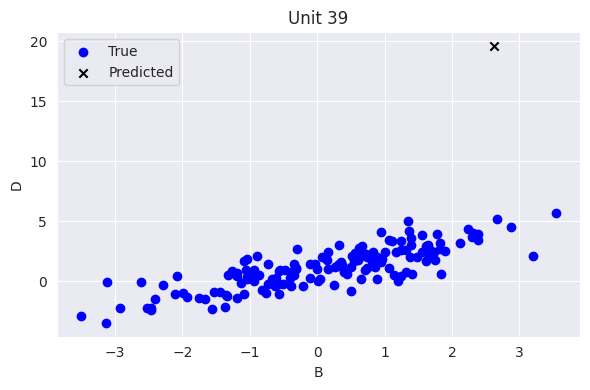

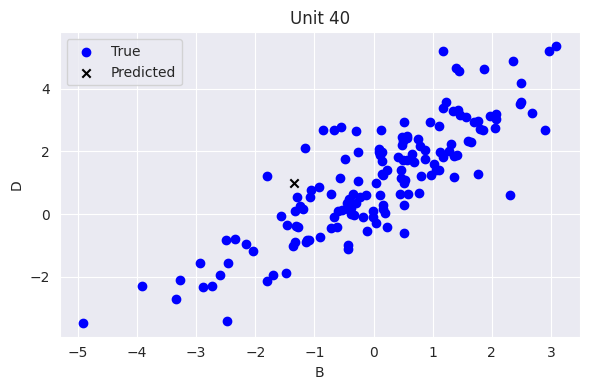

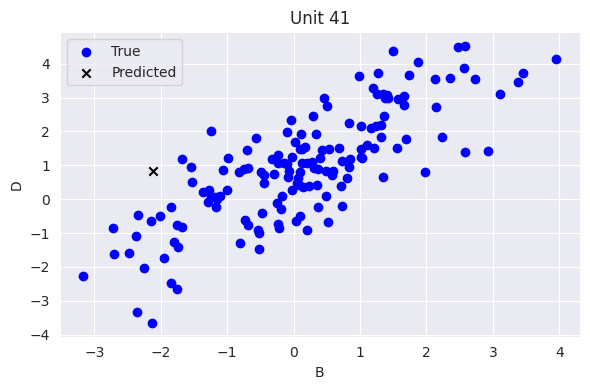

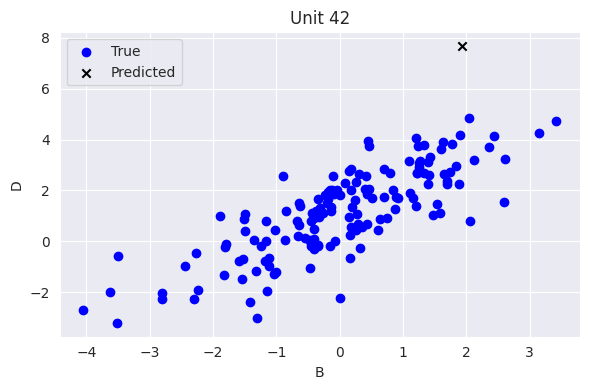

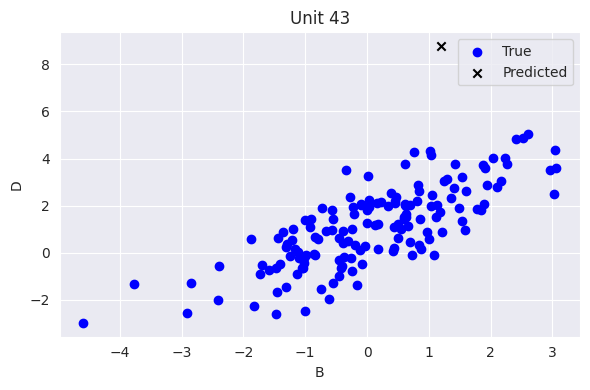

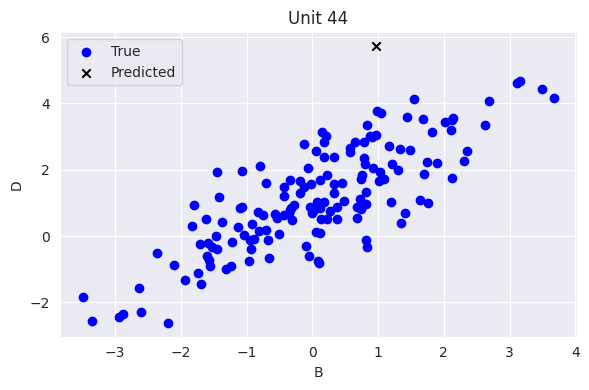

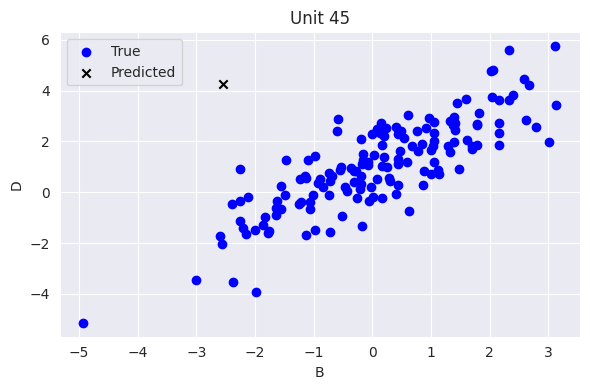

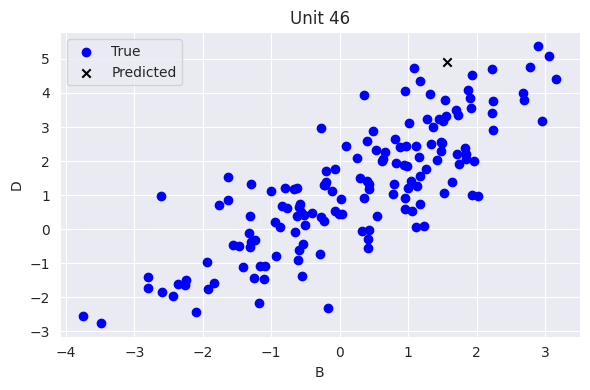

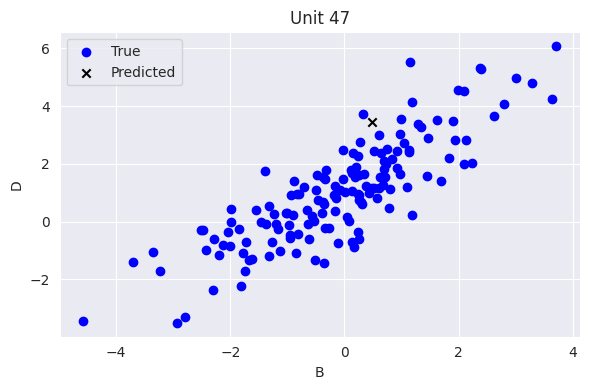

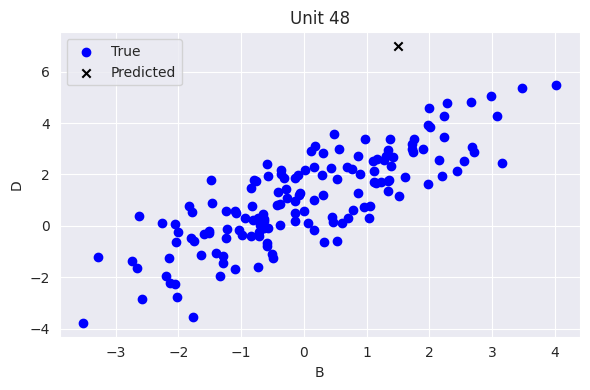

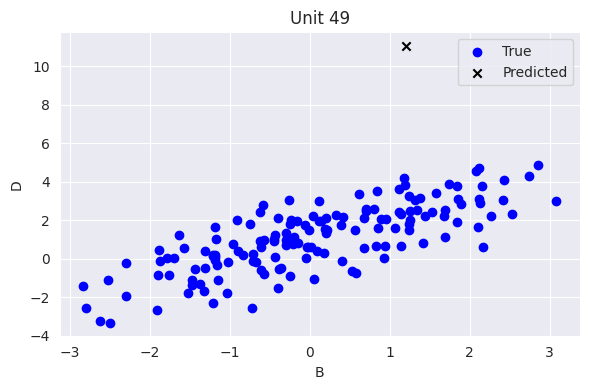

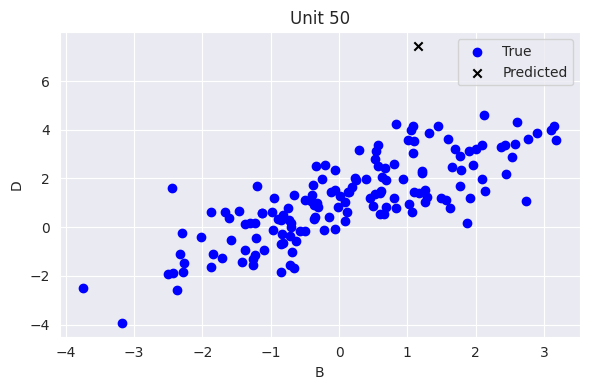

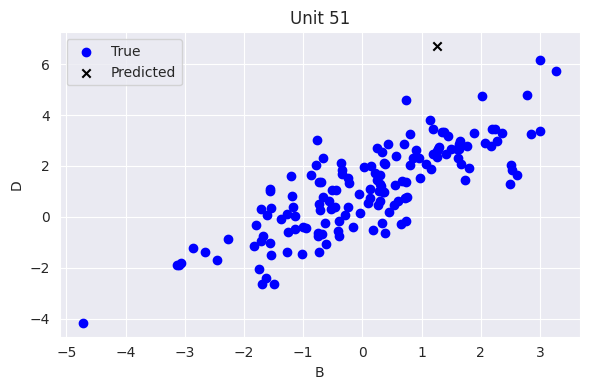

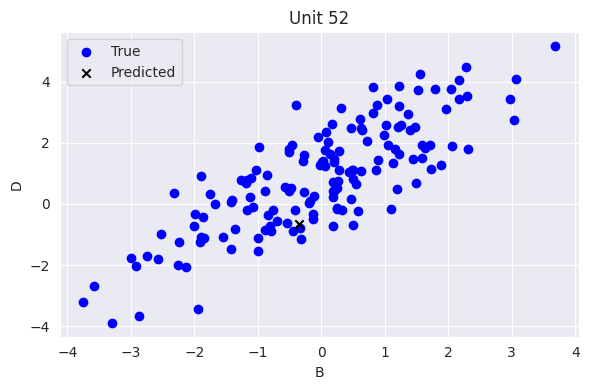

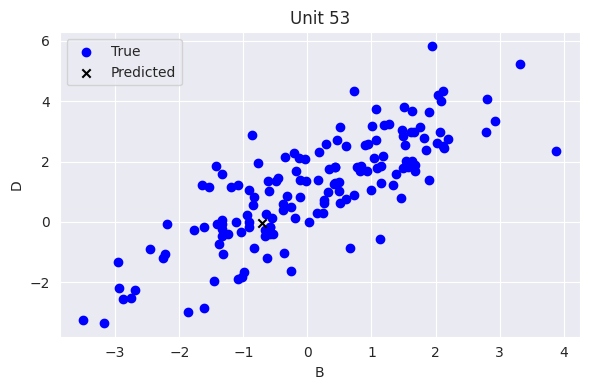

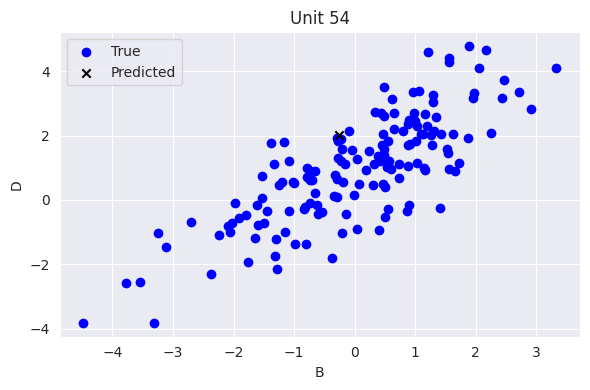

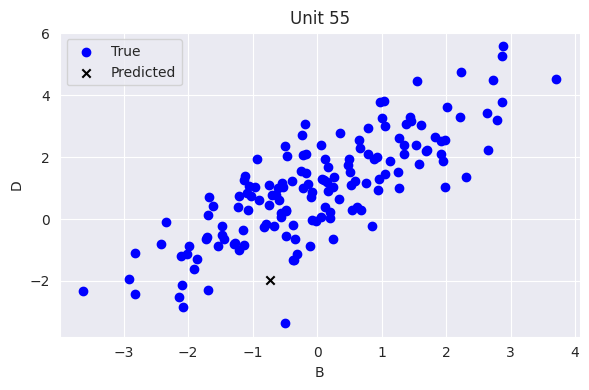

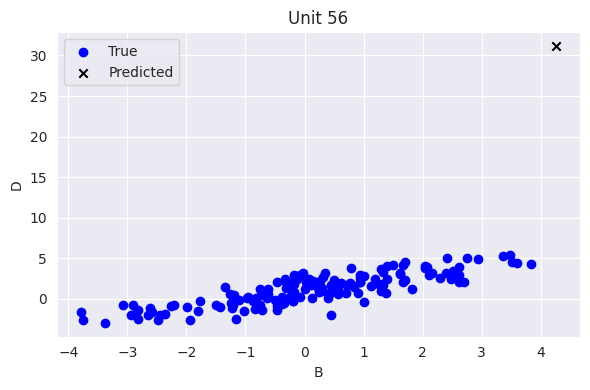

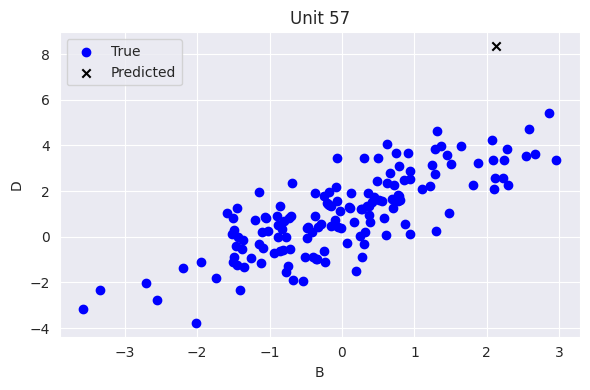

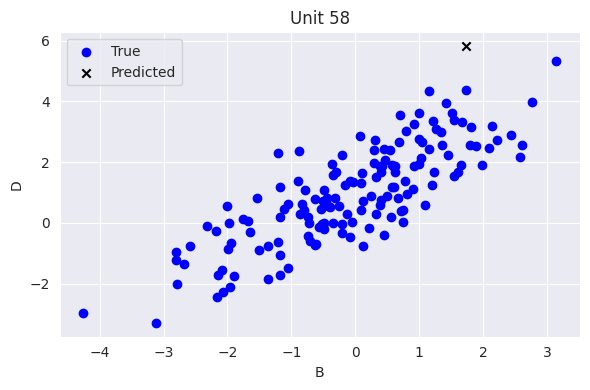

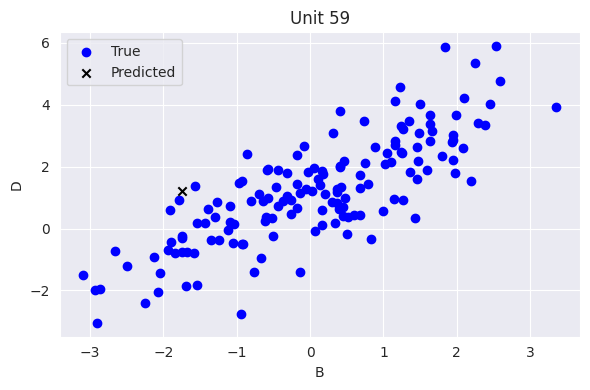

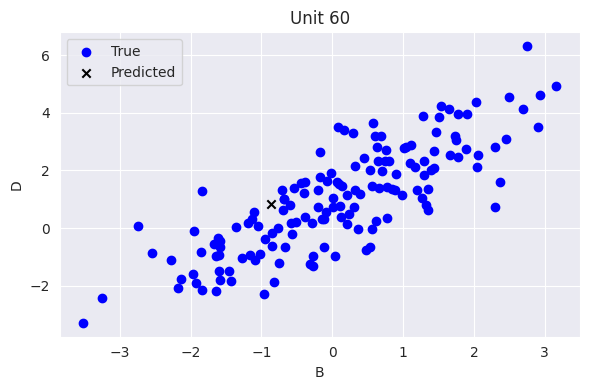

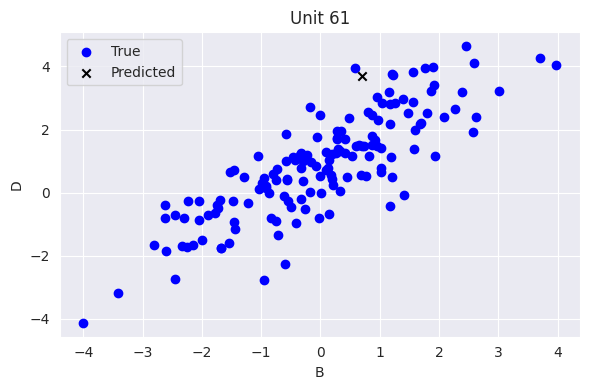

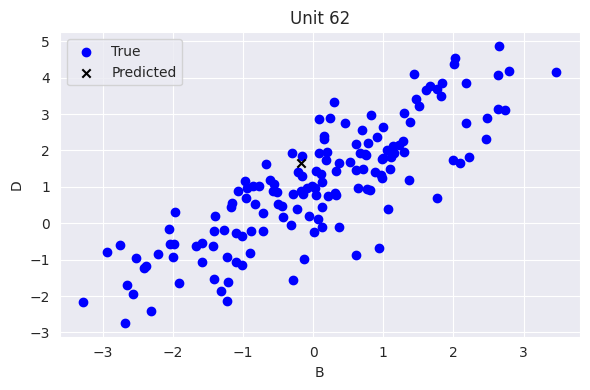

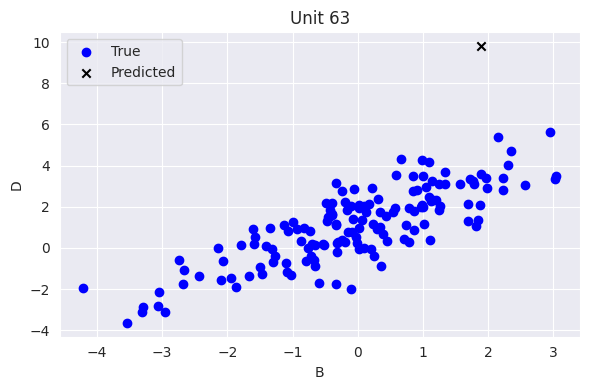

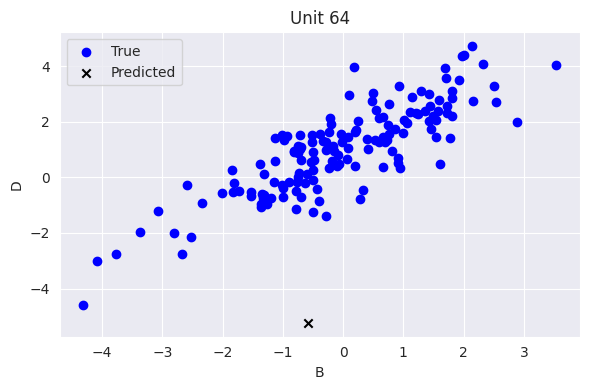

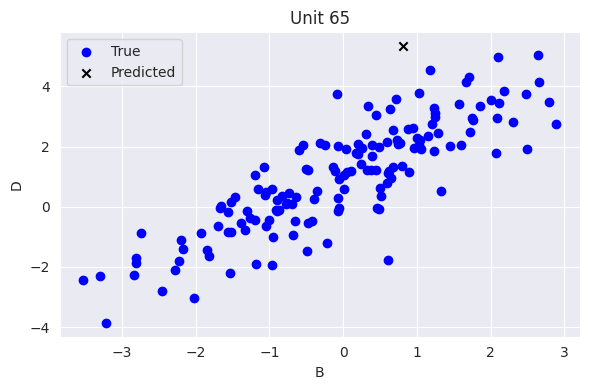

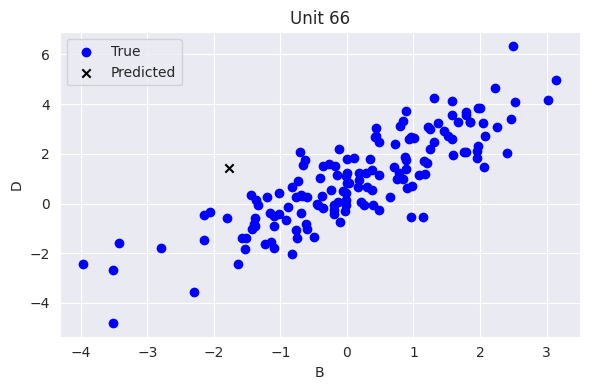

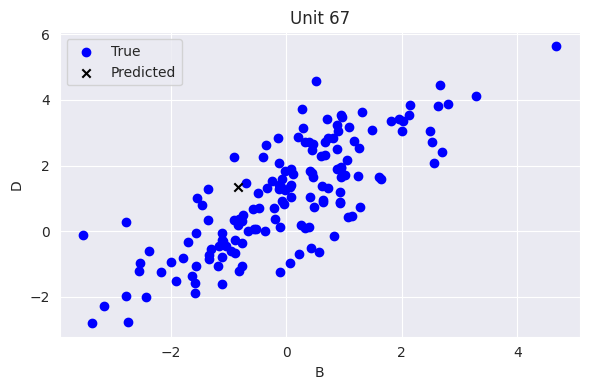

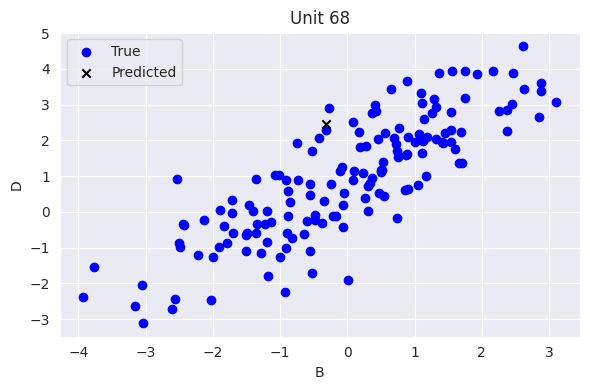

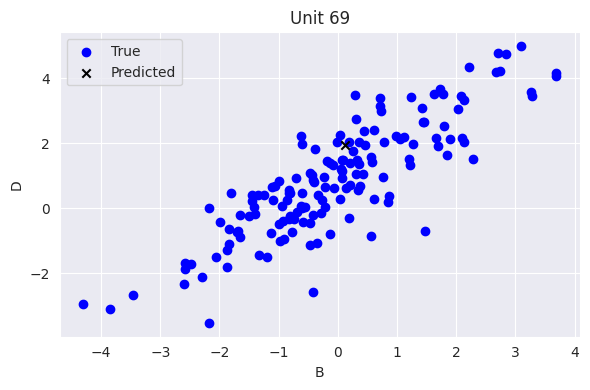

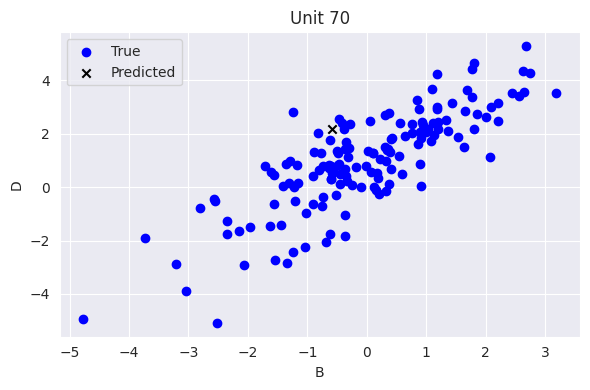

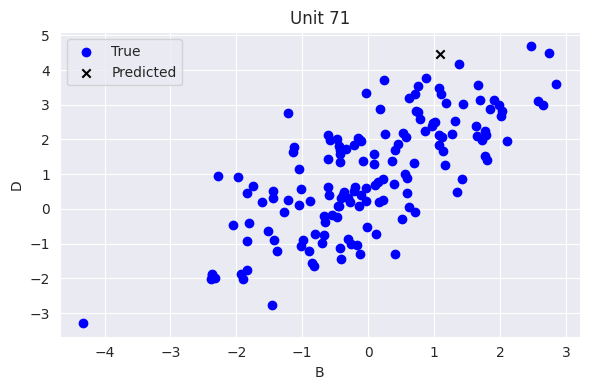

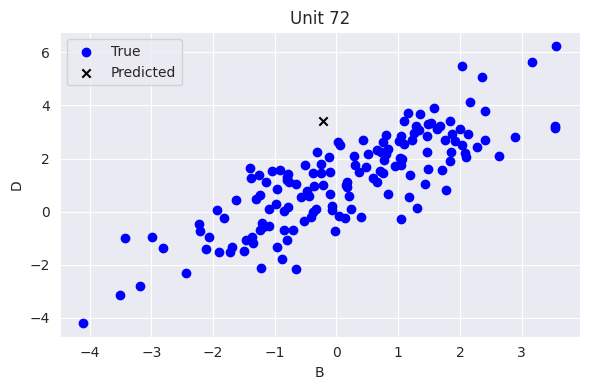

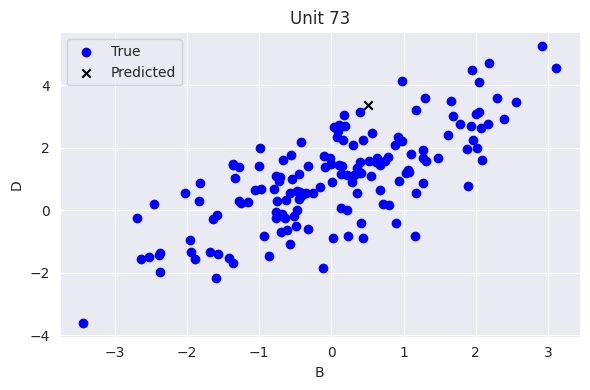

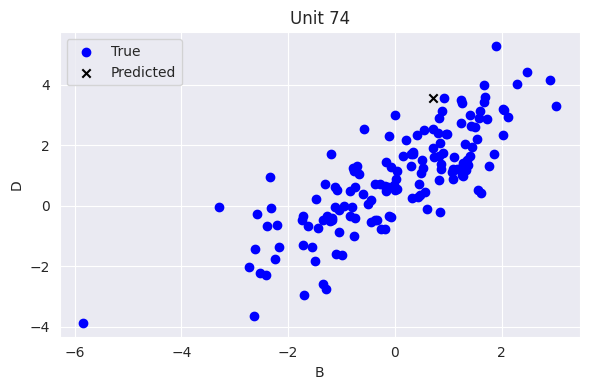

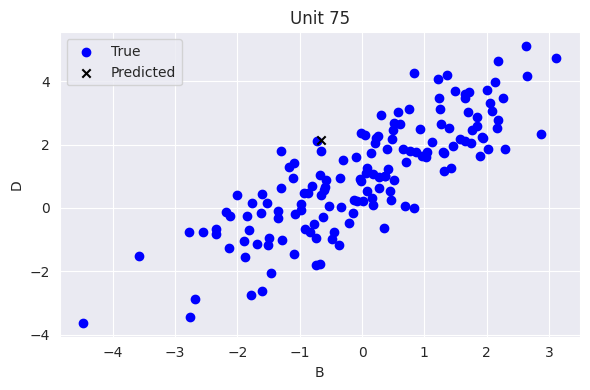

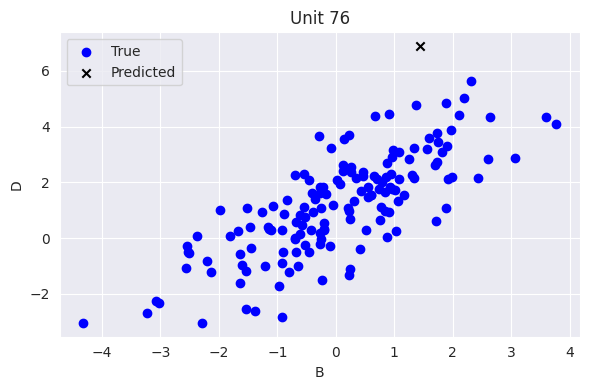

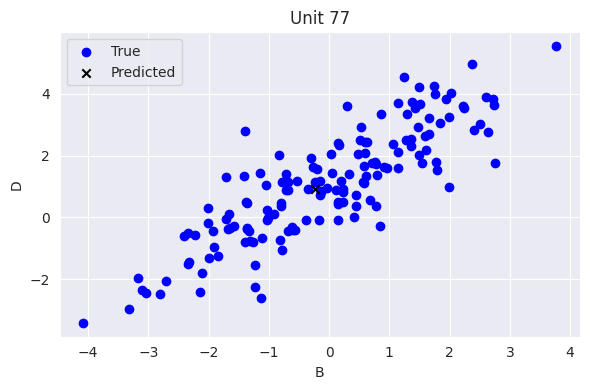

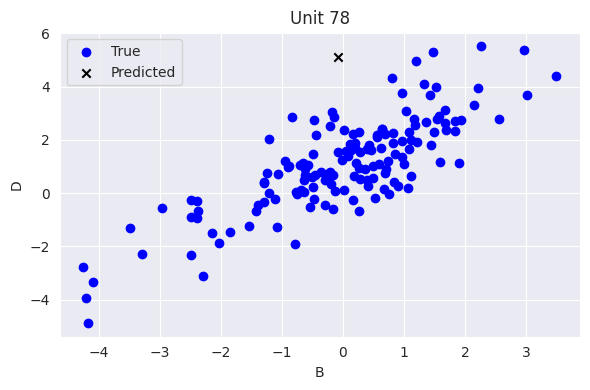

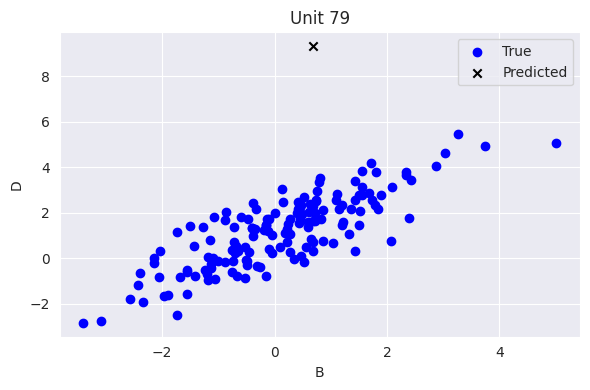

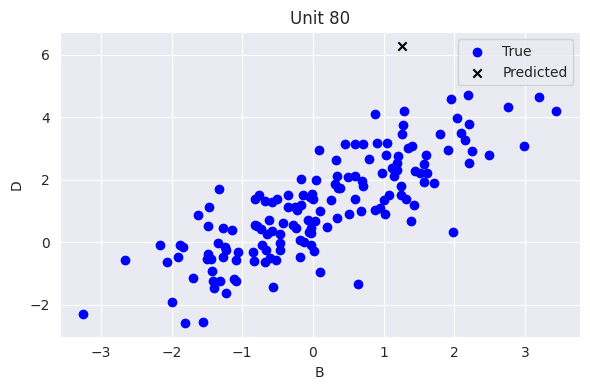

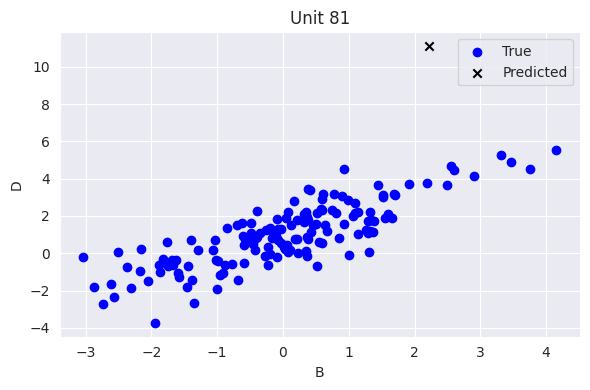

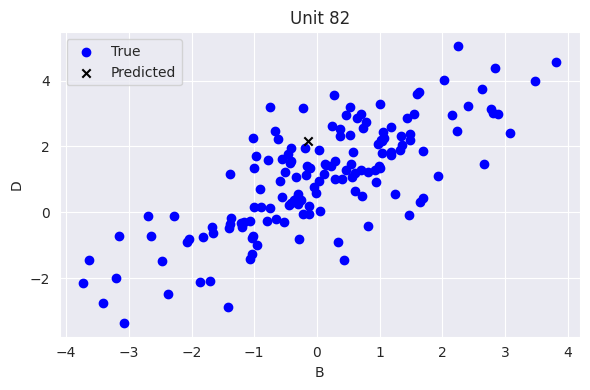

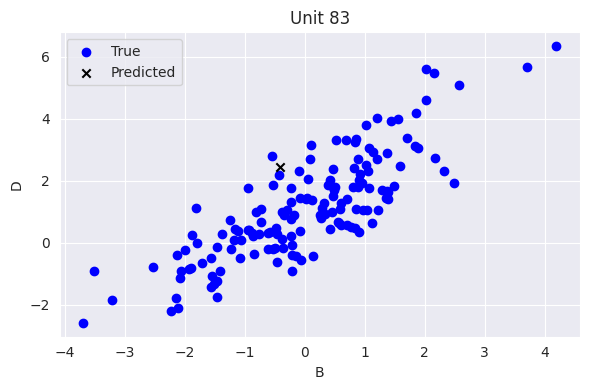

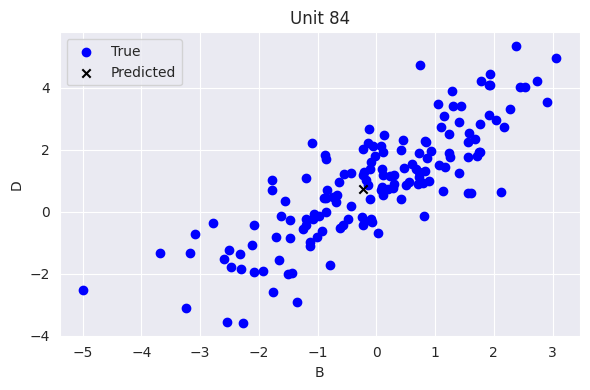

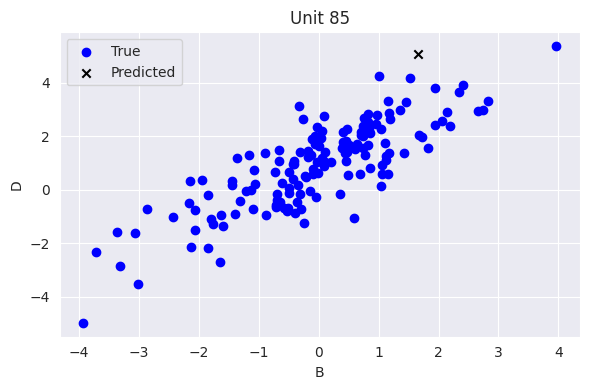

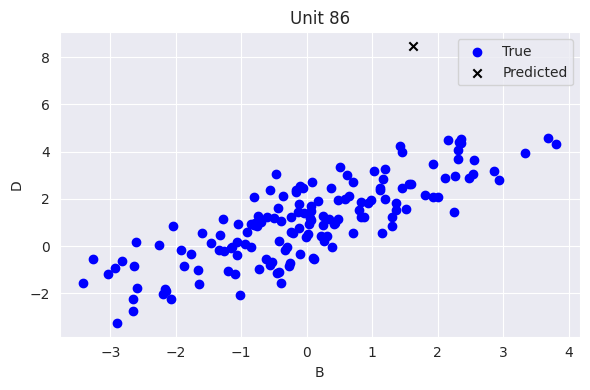

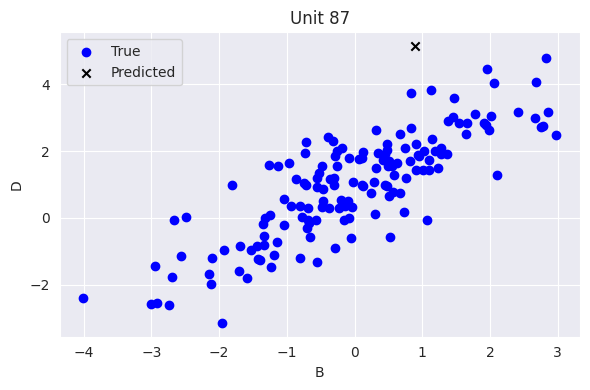

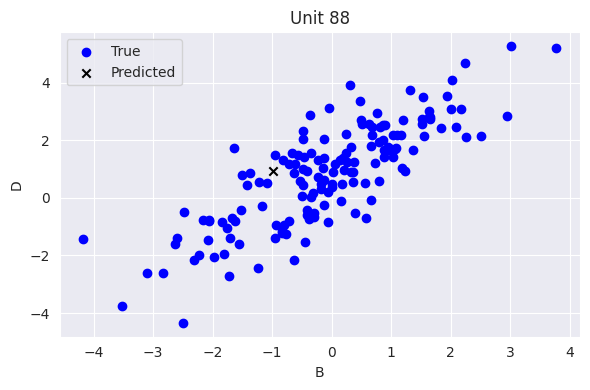

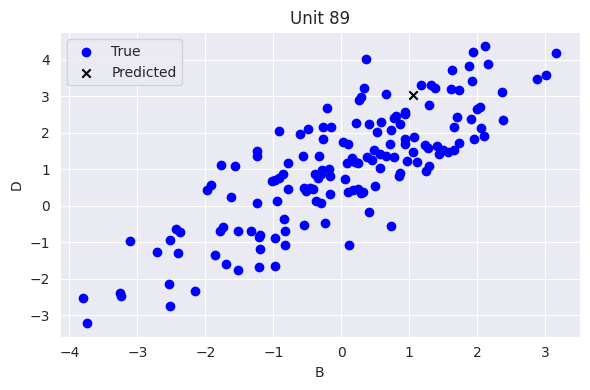

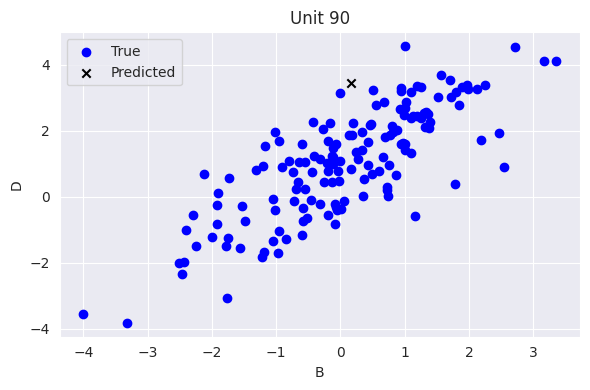

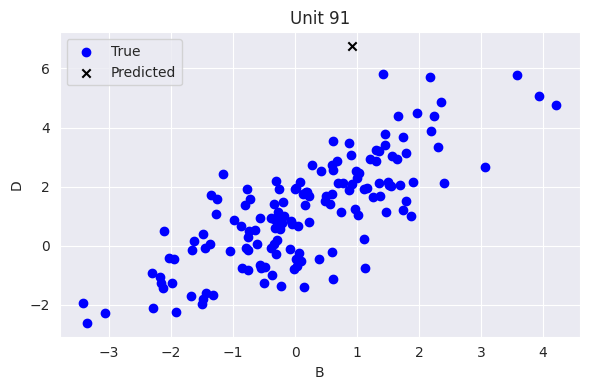

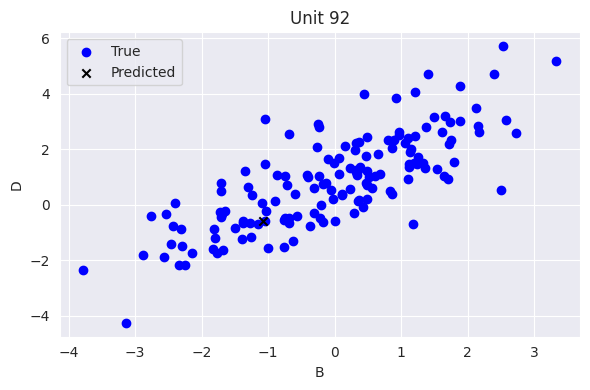

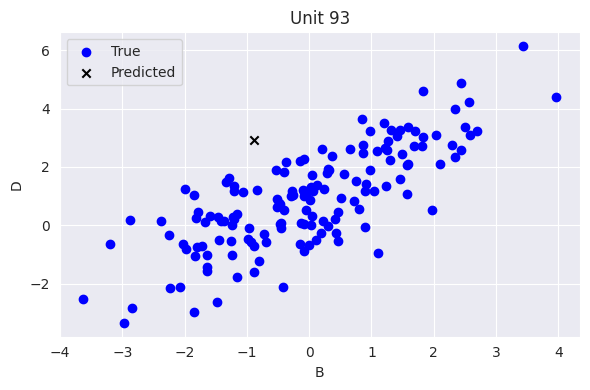

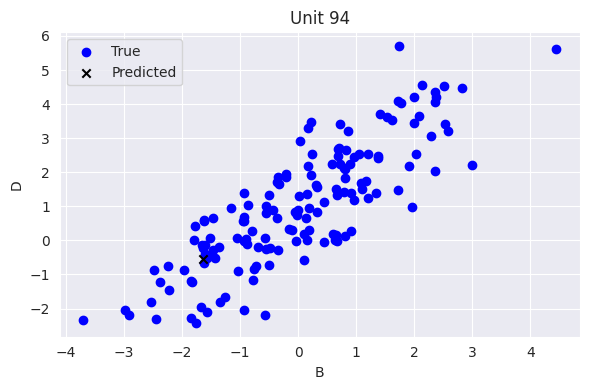

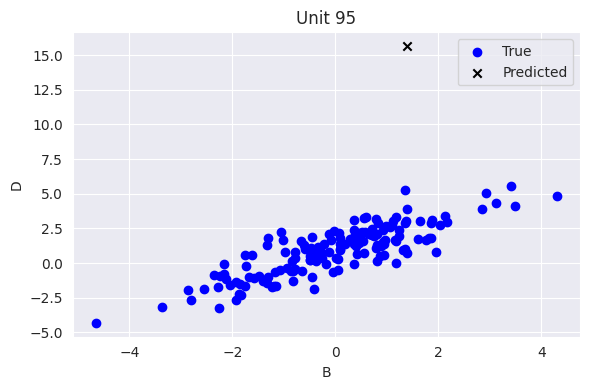

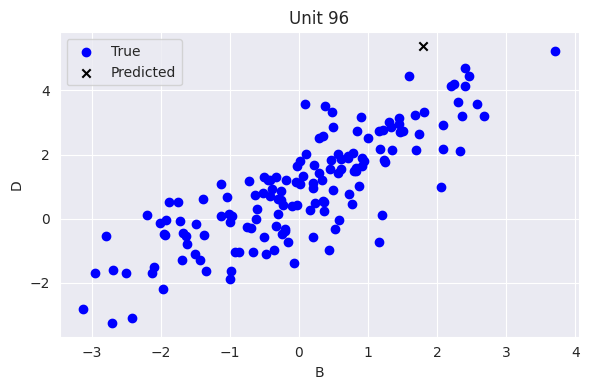

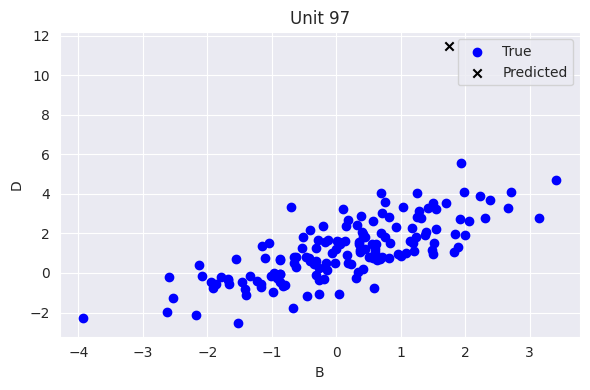

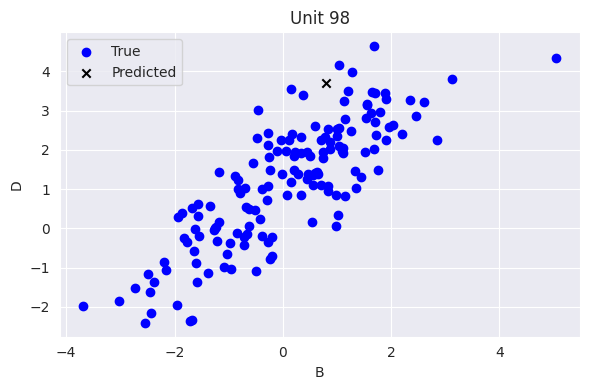

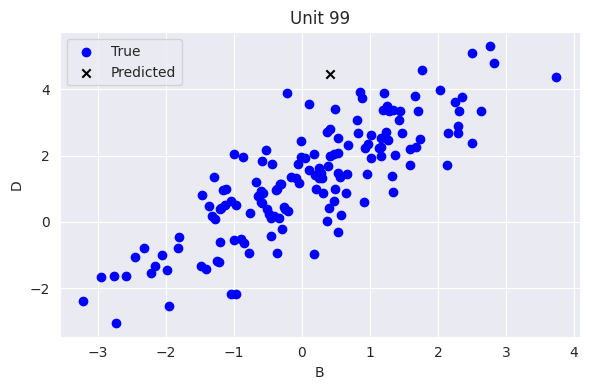

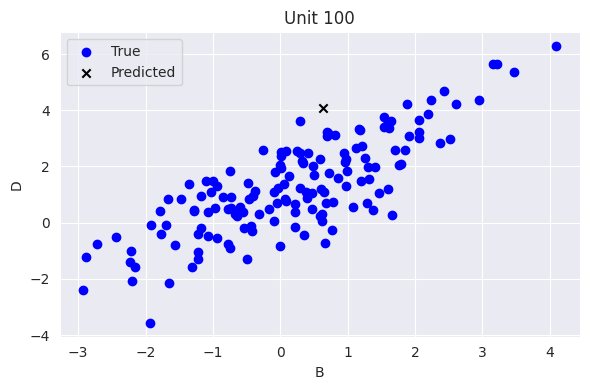

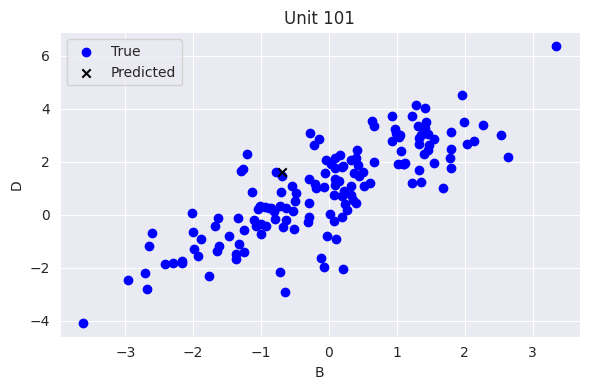

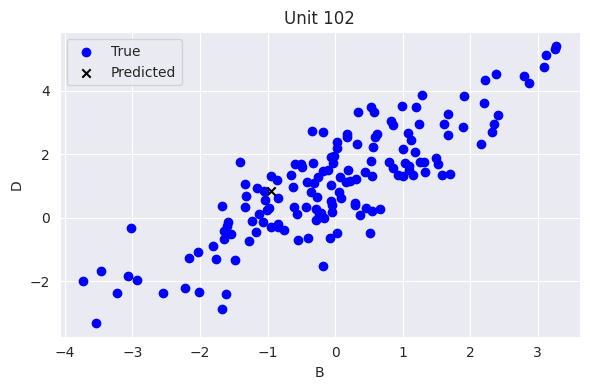

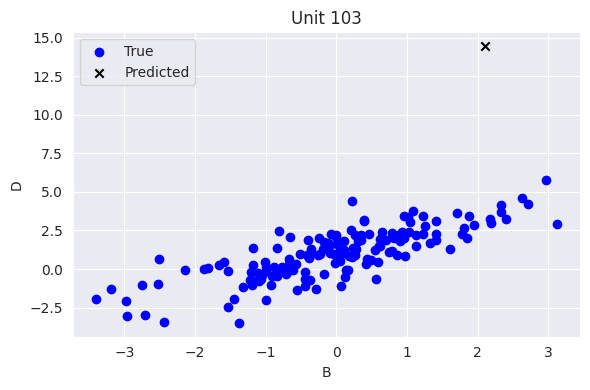

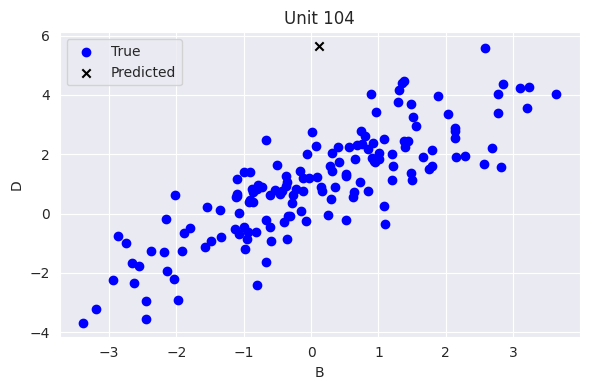

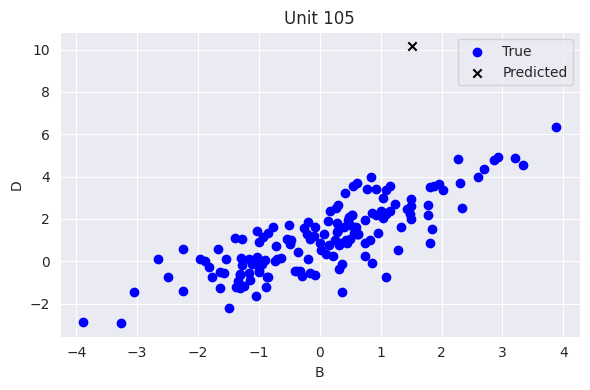

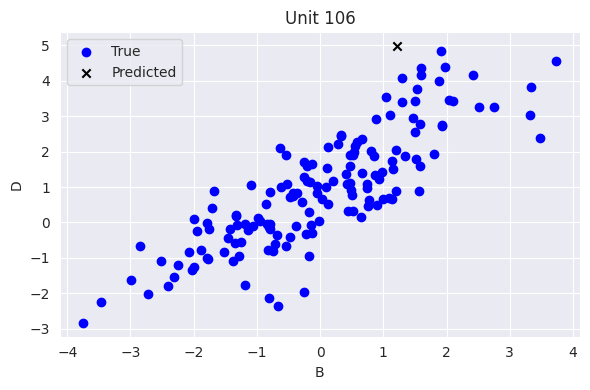

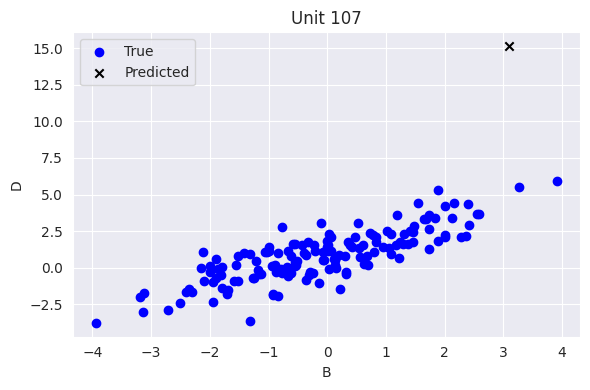

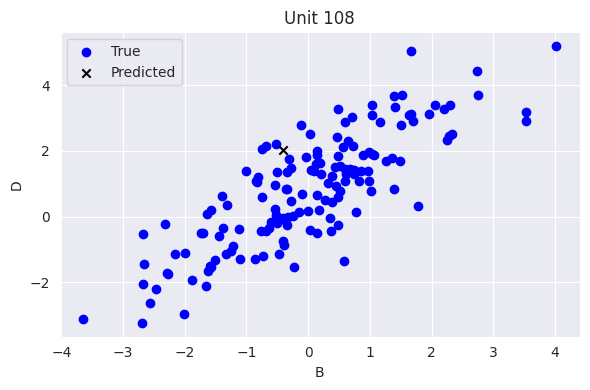

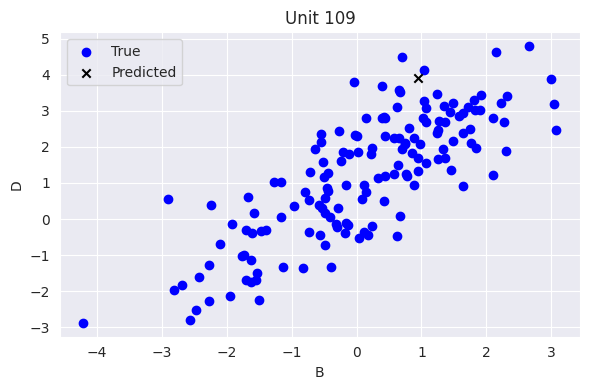

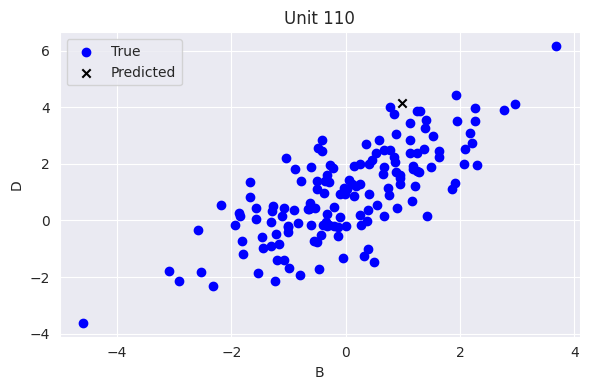

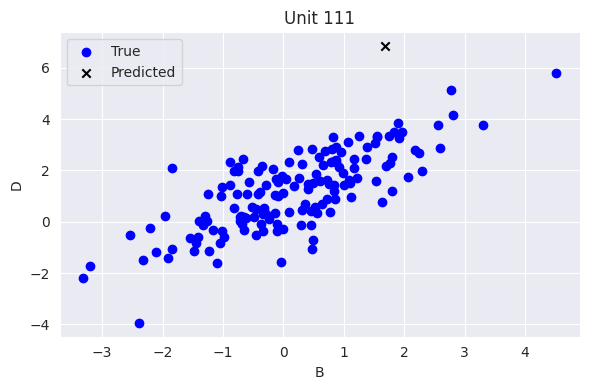

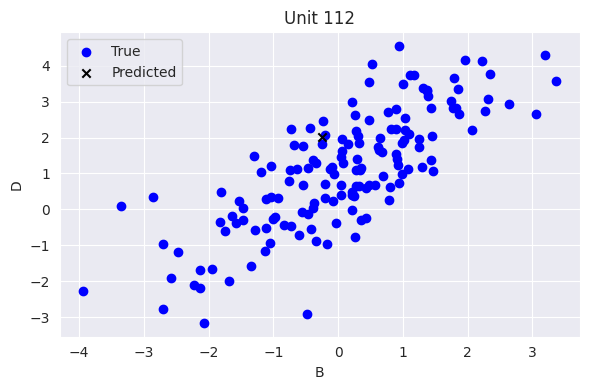

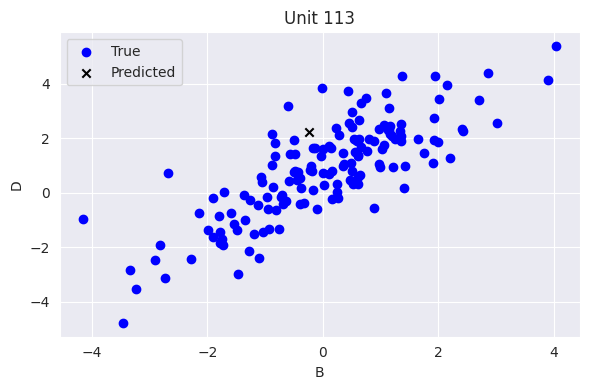

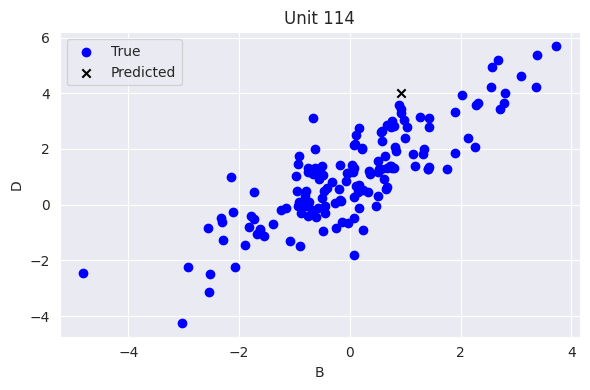

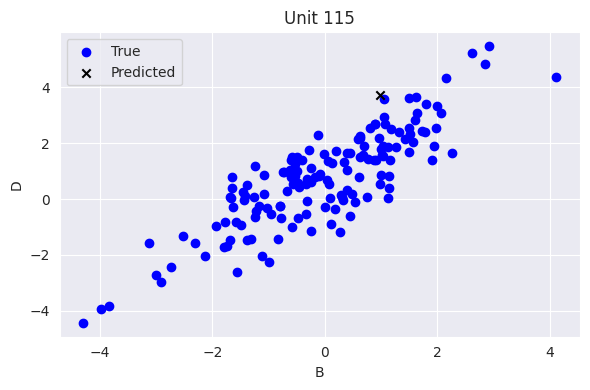

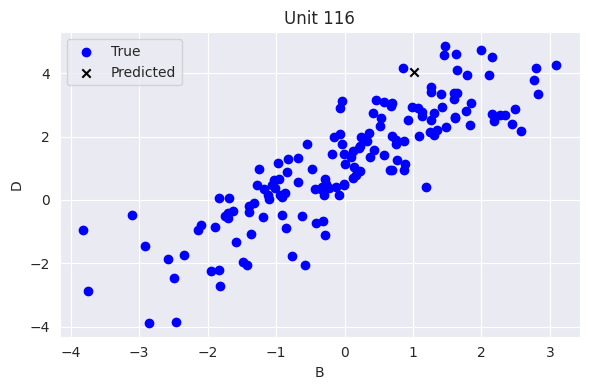

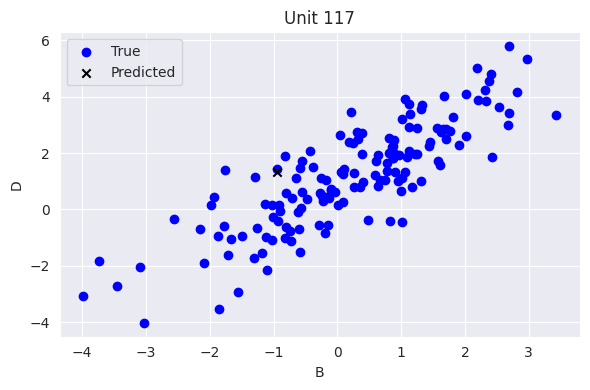

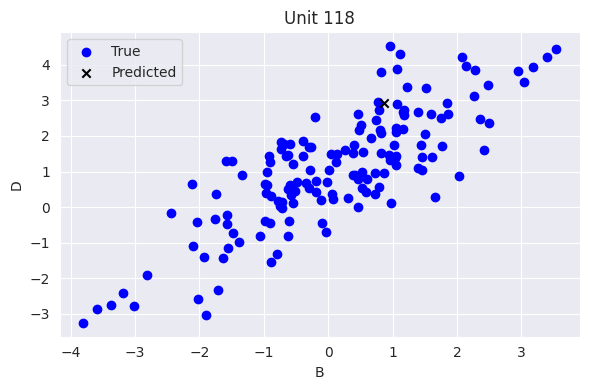

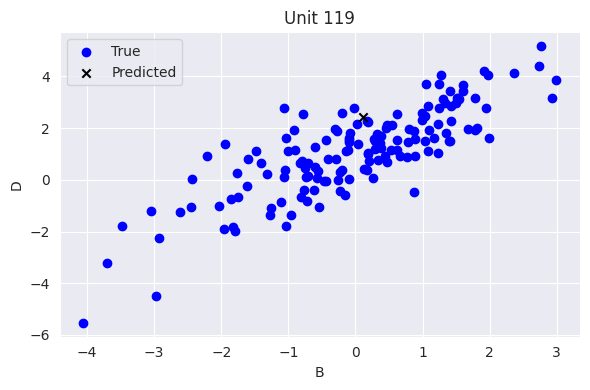

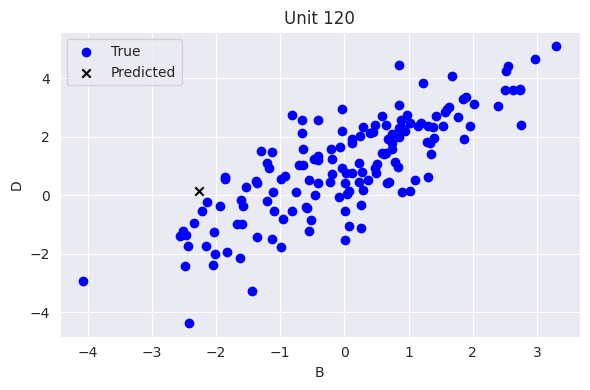

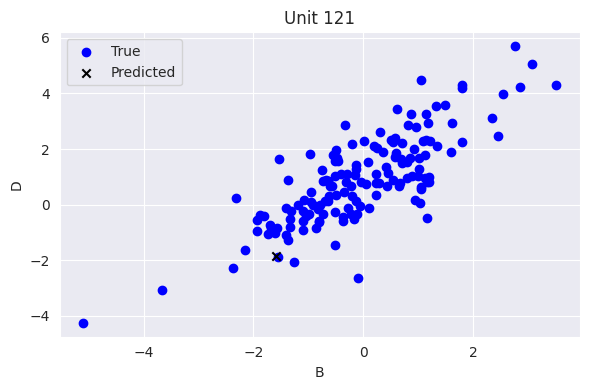

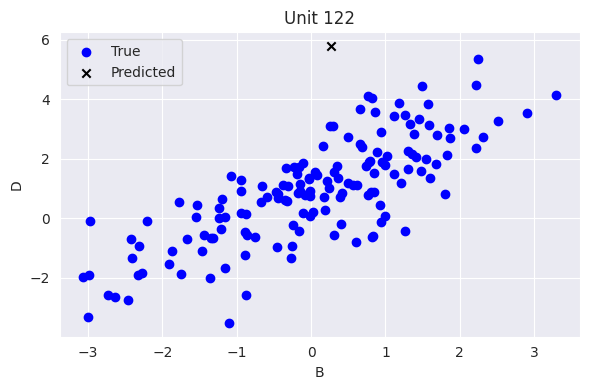

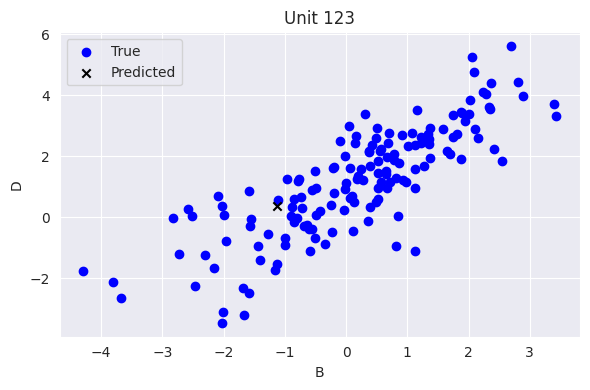

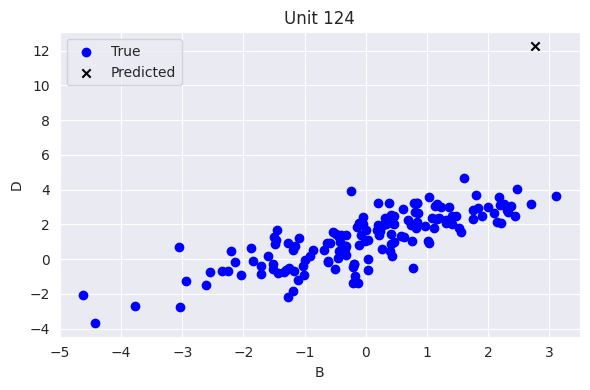

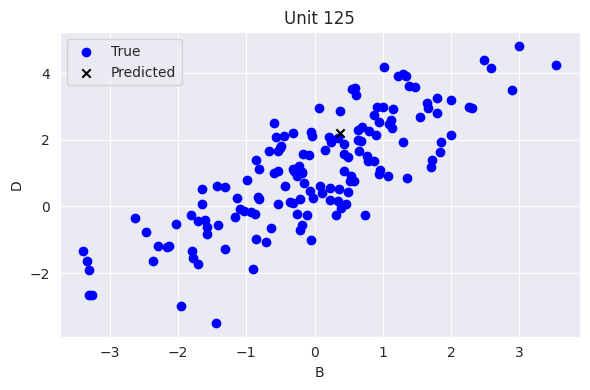

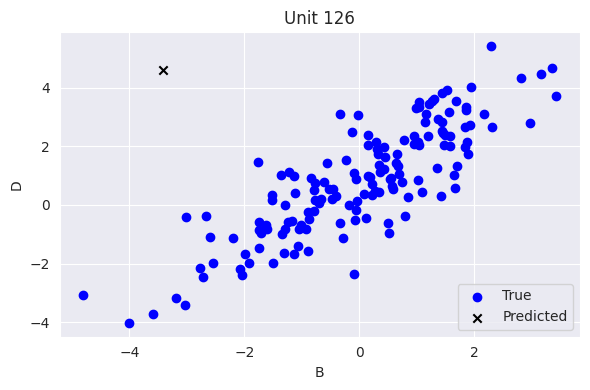

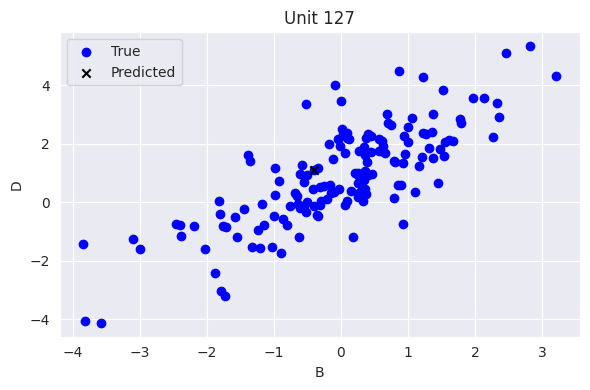

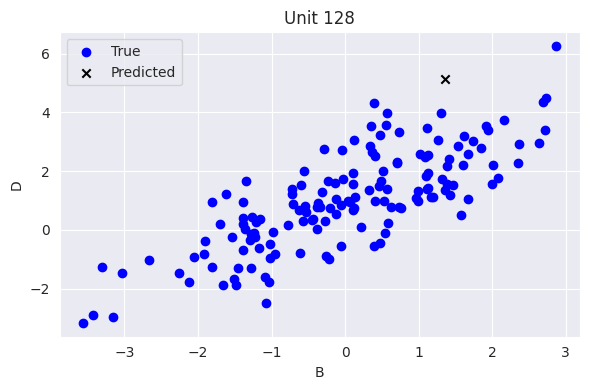

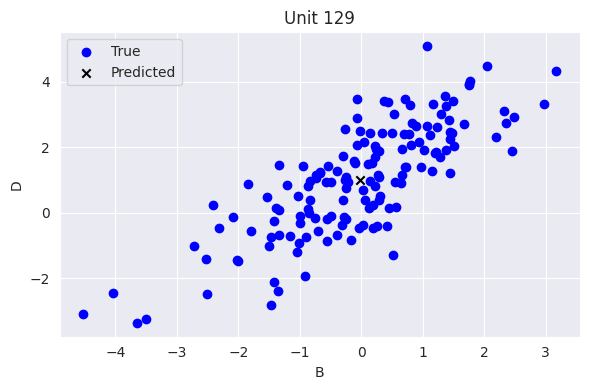

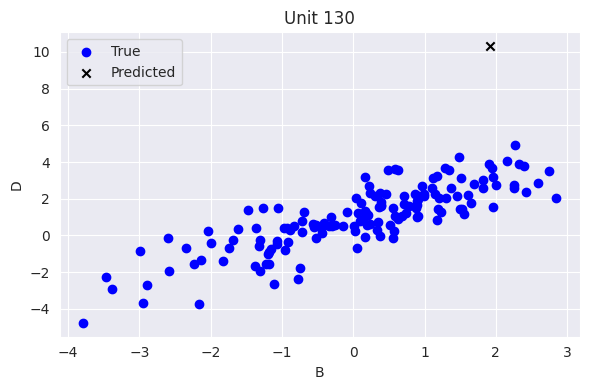

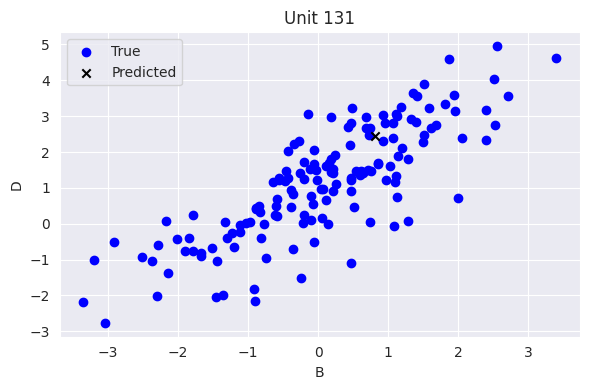

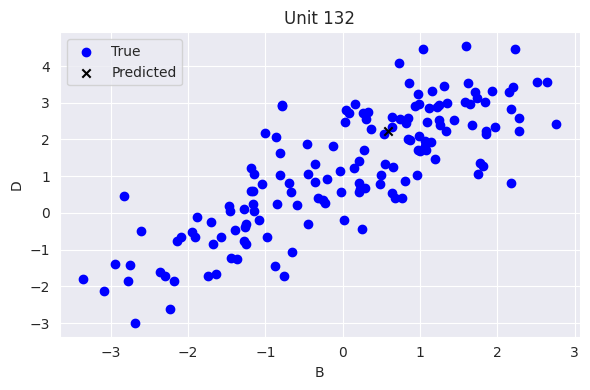

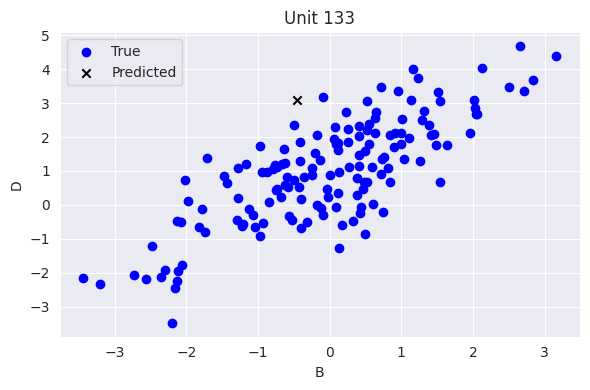

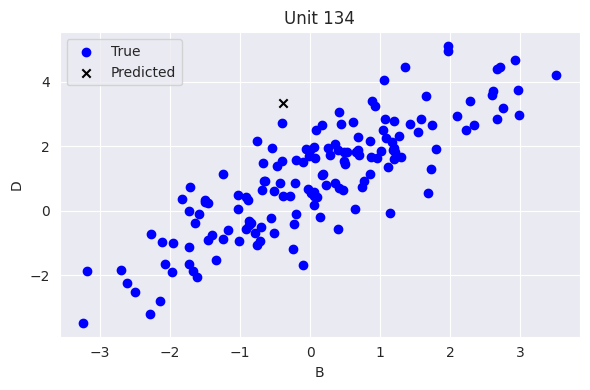

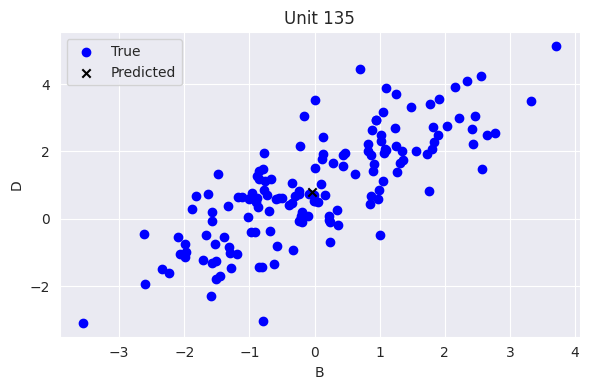

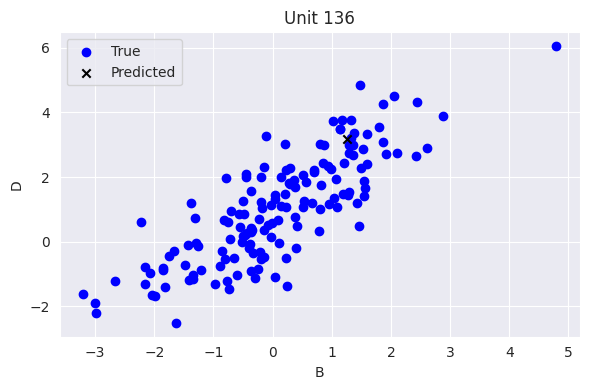

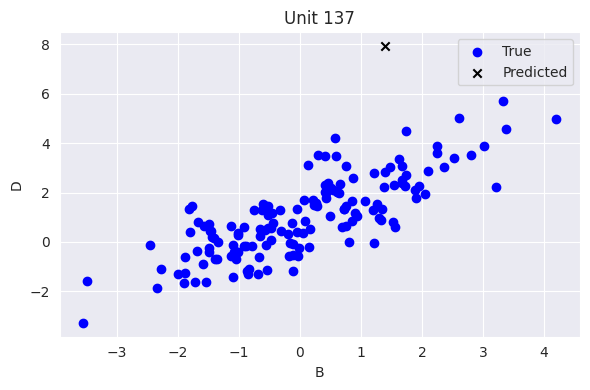

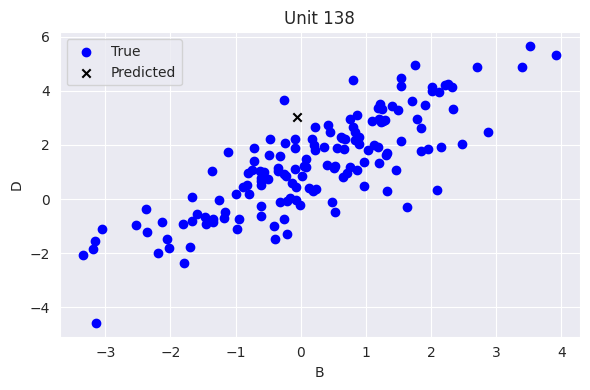

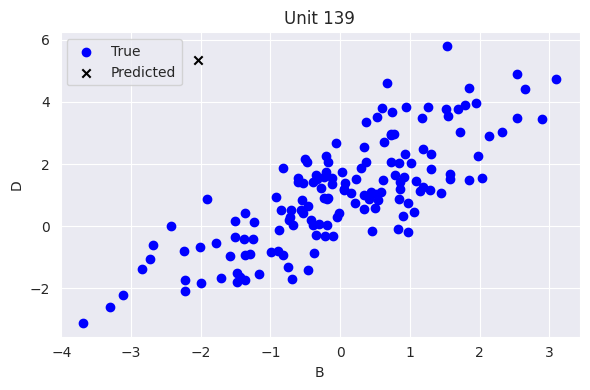

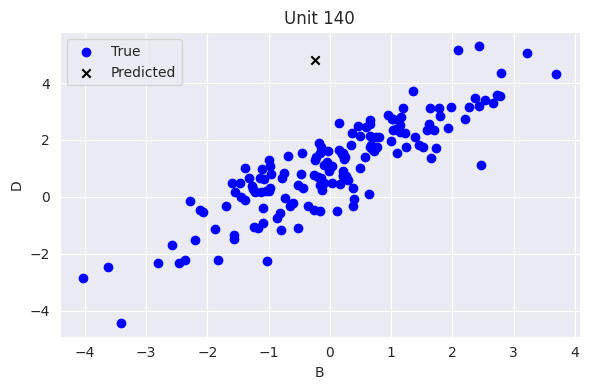

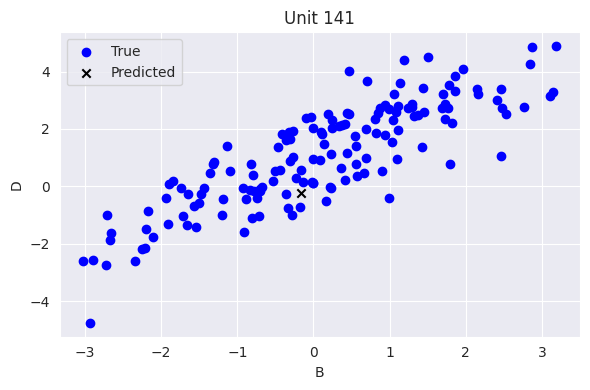

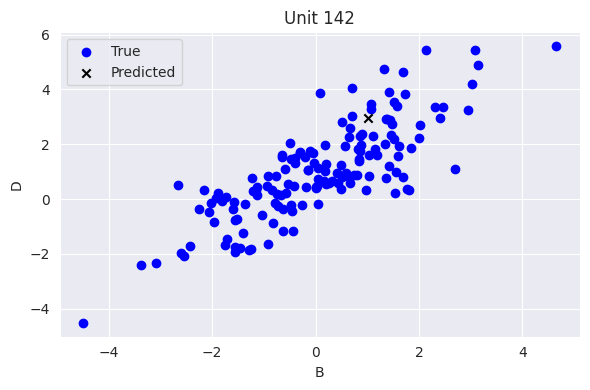

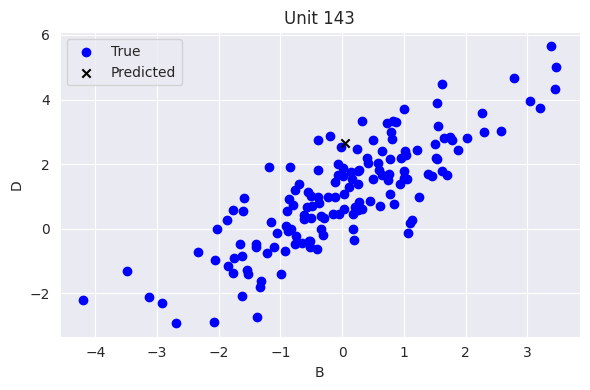

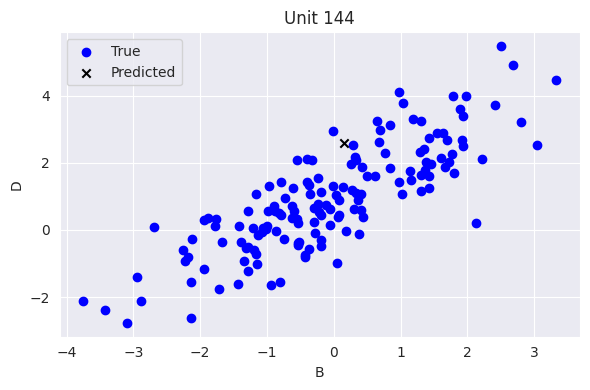

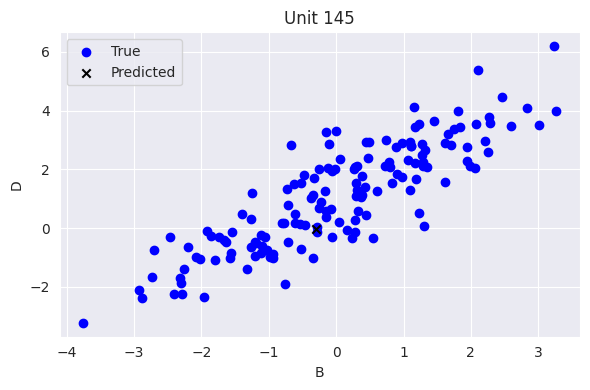

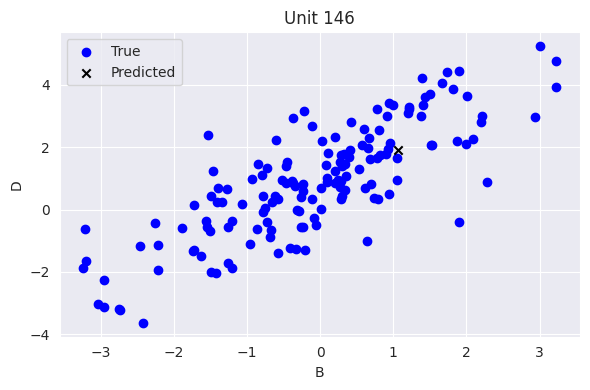

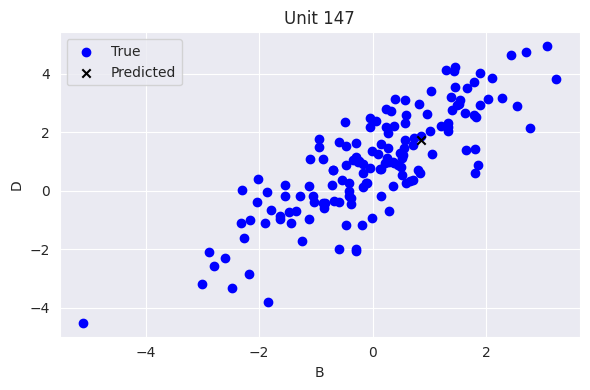

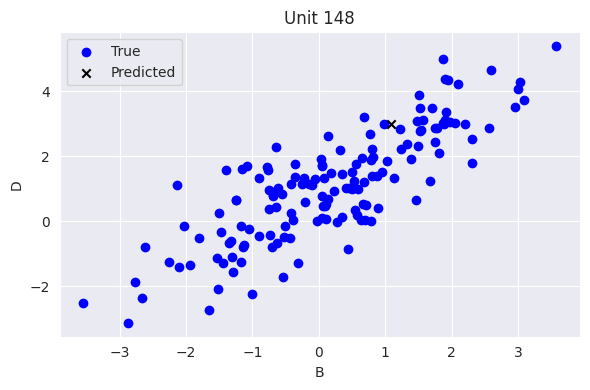

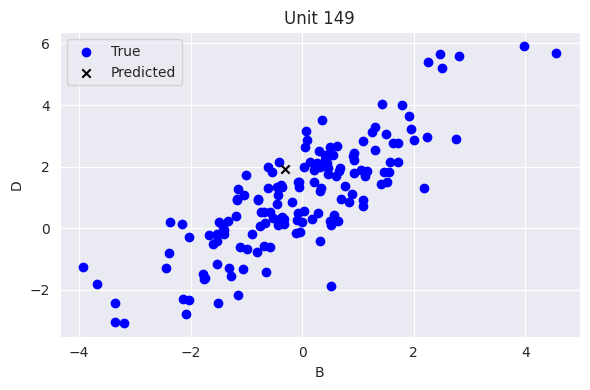

This code generates scatter plots for 50 units, comparing true and predicted values of B and D.
Each plot represents a single unit, with blue circles (o) for true values and black crosses (x) for predicted values.
The true values are taken from arrayB_full and arrayD_full, while predicted values come from b_array and d_array.
This visualization helps in understanding how well the predictions match the true values for each unit.


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming we have arrays arrayB_full, arrayD_full, b_array, and d_array
# arrayB_full and arrayD_full are the true values, b_array and d_array are the predicted values

# Colors for true and predicted values
true_color = 'blue'
pred_color = 'red'

for i in range(150):
    # Create a new figure for each unit
    plt.figure(figsize=(6, 4))
    
    # Plot true b and d values
    plt.scatter(arrayB_full[i,:], arrayD_full[i,:], color=true_color, label='True', marker='o')
    
    # Plot predicted b and d values
    # Check if the predicted values are scalars or arrays
    if np.isscalar(b_array[i]) and np.isscalar(d_array[i]):
        plt.scatter(b_array[i], d_array[i], color='black', label='Predicted', marker='x')
    else:
        plt.scatter(b_array[i], d_array[i], color='black', label='Predicted', marker='x')
    
    # Set title and labels for the plot
    plt.title(f'Unit {i}')
    plt.xlabel('B')
    plt.ylabel('D')
    plt.legend()
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Explanation of the code:
print("This code generates scatter plots for 50 units, comparing true and predicted values of B and D.")
print("Each plot represents a single unit, with blue circles (o) for true values and black crosses (x) for predicted values.")
print("The true values are taken from arrayB_full and arrayD_full, while predicted values come from b_array and d_array.")
print("This visualization helps in understanding how well the predictions match the true values for each unit.")


AUC ROC

In [26]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
from scipy.special import kl_div


In [27]:


def experiment(n):
    kldivs = []
    roc_auc_scores = []
    
    for k in range(n):
        print(f"{k} is in progress")
        
        # Load data and set up the experiment
        graph = [('a', '_b'), ('a', 'c'), ('_b', 'c'), ('c', '_d'), ('_b', '_d'), ('_d', 'e'), ('c', 'e')]
        data = load_data_from_json(f'data/sampled_data_{k}.json')
        
        unit_vars = ['a', 'c', 'e']
        subunit_vars = ['d', 'b']
        sizes = [150]*150
        
        generator = CausalGenerator(graph, data, unit_vars, subunit_vars, sizes)
        
        noise_dist = {
            'a': lambda x: norm.ppf(x),
            '_b': lambda x: norm.ppf(x, loc=0, scale=1),
            'c': lambda x: norm.ppf(x, loc=0, scale=1),
            '_d': lambda x: norm.ppf(x, loc=0, scale=1),
            'e': lambda x: norm.ppf(x, loc=0, scale=1)
        }
        
        transition_funcs = {
            '_b': lambda a: (a+1)**2,
            'c': lambda a, b: a**3 + (b+1)**2,
            '_d': lambda b, c: (b+1)**2 - c**3,
            'e': lambda c, d: c + (d+1)**2
        }
        
        generated_data = generator.generate(noise_dist, transition_funcs, sizes)
        
        # Generate arrays for each variable
        a_array = np.array([generated_data[f'a{i}'] for i in range(len(sizes))])
        b_array = np.array([generated_data[f'_b{i}'] for i in range(len(sizes))])
        c_array = np.array([generated_data[f'c{i}'] for i in range(len(sizes))])
        d_array = np.array([generated_data[f'_d{i}'] for i in range(len(sizes))])
        e_array = np.array([generated_data[f'e{i}'] for i in range(len(sizes))])
        
        # Get arrays from original data
        arrayA = np.array([data[f'a{i}'] for i in range(150)])
        arrayB = np.array([np.mean([data[f'_b{i}_{j}'] for j in range(150)]) for i in range(150)])
        arrayC = np.array([data[f'c{i}'] for i in range(150)])
        arrayD = np.array([np.mean([data[f'_d{i}_{j}'] for j in range(150)]) for i in range(150)])
        arrayE = np.array([data[f'e{i}'] for i in range(150)])
        
        # Calculate KL divergence
        kldiv = {
            'a': kl_divergence(arrayA, a_array),
            'b': kl_divergence(arrayB, b_array),
            'c': kl_divergence(arrayC, c_array),
            'd': kl_divergence(arrayD, d_array),
            'e': kl_divergence(arrayE, e_array)
        }
        kldivs.append(kldiv)
        
        # Prepare data for KNN classification
        X = np.concatenate([a_array, b_array, c_array, d_array, e_array, 
                            arrayA, arrayB, arrayC, arrayD, arrayE])
        y = np.concatenate([np.ones(len(a_array) * 5), np.zeros(len(arrayA) * 5)])
        
        # Split data for training and testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        
        # Train KNN classifier
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train.reshape(-1, 1), y_train)
        
        # Predict and calculate ROC AUC score
        y_pred = knn.predict_proba(X_test.reshape(-1, 1))[:, 1]
        roc_auc = roc_auc_score(y_test, y_pred)
        roc_auc_scores.append(roc_auc)
        
        print(f"ROC AUC Score for iteration {k}: {roc_auc}")
    
    # Print average ROC AUC score
    avg_roc_auc = np.mean(roc_auc_scores)
    std=np.std(roc_auc_scores)
    print(f"Average ROC AUC Score: {avg_roc_auc}")
    print(f"Std ROC AUC SCORE : {std}")
    
    return kldivs, roc_auc_scores


0 is in progress
Data successfully loaded from data/sampled_data_0.json
ROC AUC Score for iteration 0: 0.6938963144574501
1 is in progress
Data successfully loaded from data/sampled_data_1.json
ROC AUC Score for iteration 1: 0.6932537171781082
2 is in progress
Data successfully loaded from data/sampled_data_2.json
ROC AUC Score for iteration 2: 0.6644752451755774
3 is in progress
Data successfully loaded from data/sampled_data_3.json
ROC AUC Score for iteration 3: 0.7010340873141412
4 is in progress
Data successfully loaded from data/sampled_data_4.json
ROC AUC Score for iteration 4: 0.6836147579879784
5 is in progress
Data successfully loaded from data/sampled_data_5.json
ROC AUC Score for iteration 5: 0.6718008541600758
6 is in progress
Data successfully loaded from data/sampled_data_6.json
ROC AUC Score for iteration 6: 0.6588401613413477
7 is in progress
Data successfully loaded from data/sampled_data_7.json
ROC AUC Score for iteration 7: 0.6948256089844986
8 is in progress
Data su

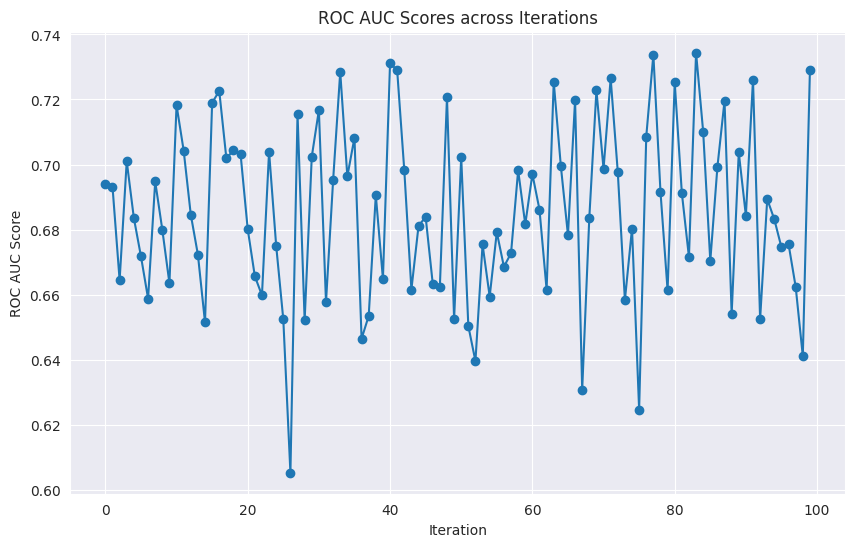

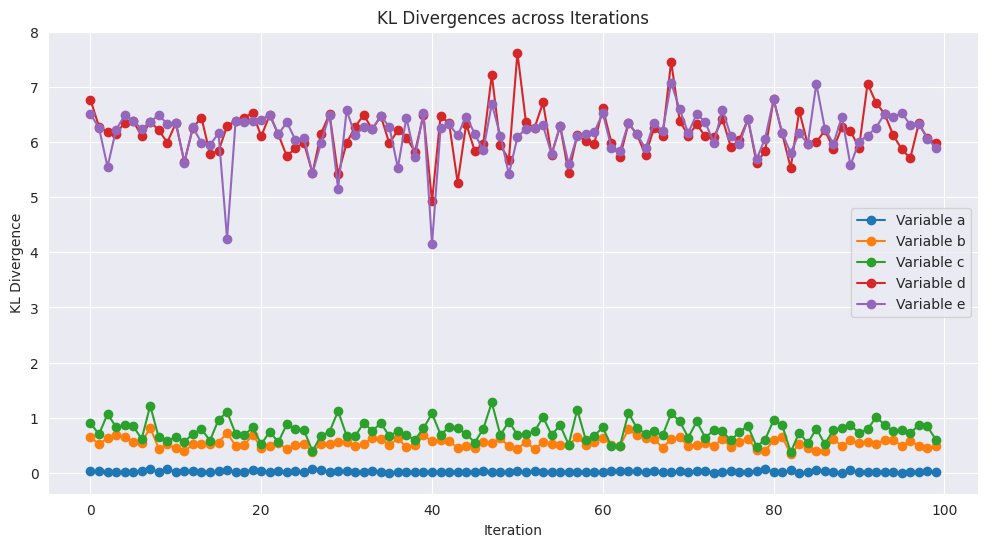

In [28]:

# Run the experiment
n_iterations = 100  # You can adjust this number
kldivs, roc_auc_scores = experiment(n_iterations)

# Plot ROC AUC scores
plt.figure(figsize=(10, 6))
plt.plot(range(n_iterations), roc_auc_scores, marker='o')
plt.title('ROC AUC Scores across Iterations')
plt.xlabel('Iteration')
plt.ylabel('ROC AUC Score')
plt.grid(True)
plt.show()

# Plot KL divergences
plt.figure(figsize=(12, 6))
for var in ['a', 'b', 'c', 'd', 'e']:
    kl_values = [kldiv[var] for kldiv in kldivs]
    plt.plot(range(n_iterations), kl_values, marker='o', label=f'Variable {var}')
plt.title('KL Divergences across Iterations')
plt.xlabel('Iteration')
plt.ylabel('KL Divergence')
plt.legend()
plt.grid(True)
plt.show()
